<a href="https://colab.research.google.com/github/miquelaingalls/Great-Salt-Lake-2026/blob/main/GSL_Statistical_Analyses.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# import dependencies
import numpy as np
import matplotlib.pyplot as plt
from scipy import interpolate
import pandas as pd

# mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# set working directory
import os
os.chdir('/content/drive/My Drive/GSL_d18O_model')

print(f"Current working directory: {os.getcwd()}")

Mounted at /content/drive
Current working directory: /content/drive/My Drive/GSL_d18O_model


# Read in merged dataset of model output and natural sample data.

In [ ]:
merged_gsl_data = pd.read_excel("gsl_d18O_model_with_saltair.xlsx")

# Statistical analyses
In this section, we assess statistical relationships between model predictions and measured values of carbonate facies to evaluate the model fit and whether shoreline carbonate sediments record the lake water isotopic evolution.

In the first test, we evaluate whether the apparent positive relationships between the measured **oxygen** isotopic composition of the outermost layer of microbialite sampled at Site B during the lake lowstand interval of 2022-2023 and model prediction, time, and lake level are statistically significant. This will be tested using a Pearson's correlation coefficient and the p-value of that correlation.

In the second set of tests, we will make the same evaluations but of the **carbon** isotopic compositions.

In the third set of tests, we will assess the relationship between lake level and δ$^{18}O$$_{carb}$ of each facies and the shuttle-derived sediment.

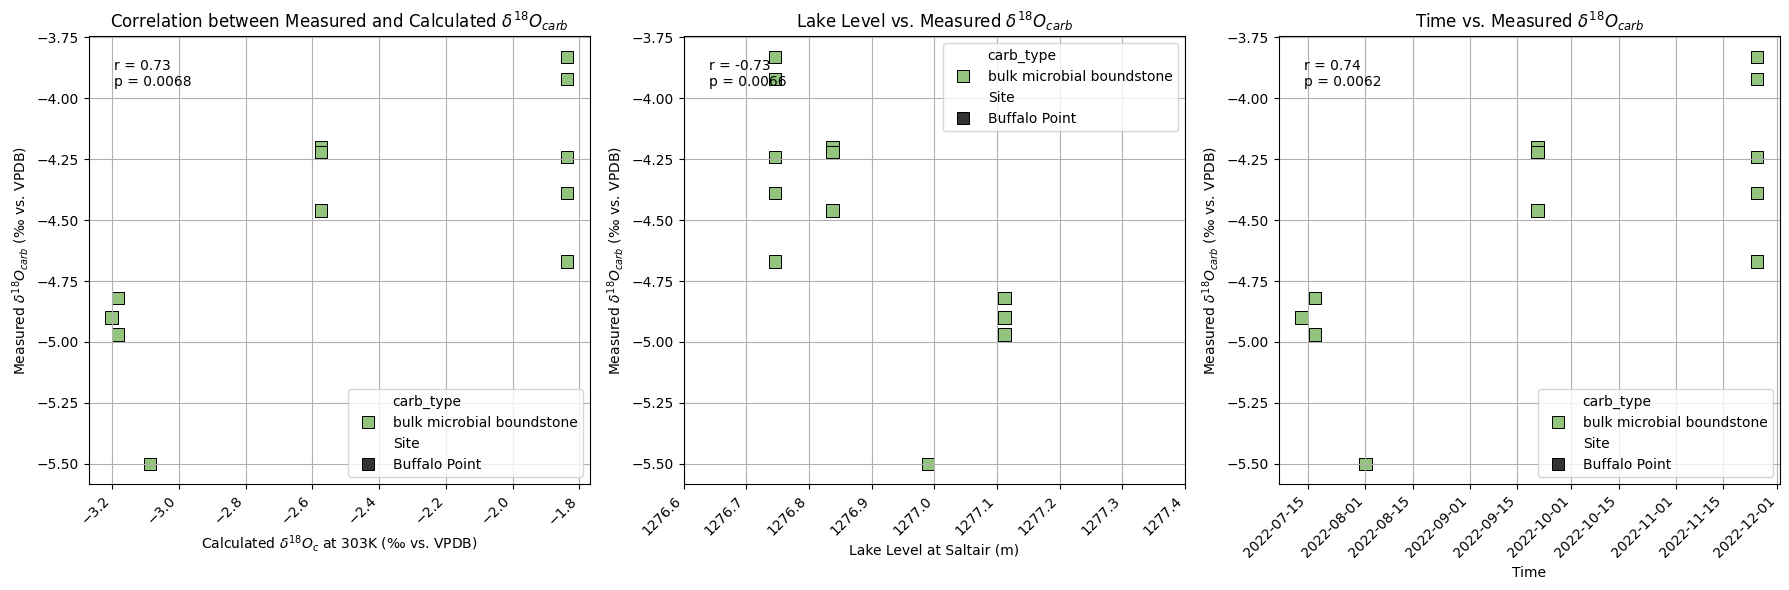

In [ ]:
# import dependencies
import numpy as np
import matplotlib.pyplot as plt
from scipy import interpolate
import pandas as pd
from scipy.stats import pearsonr
import seaborn as sns
import re

# Define markers and colors for sample data based on 'Site' and 'carb_type'
site_markers = {'Ladyfinger Point': 'D', 'Buffalo Point': 's', 'Antelope Island Causeway': 'o'}
carb_colors = {'bulk microbial boundstone': '#93c47d', 'crust': '#b4a7d6', 'white intraclast': '#ece9c9', 'bulk mud': '#351c75', 'grain coating': '#a64d79'}

# Define samples to exclude
samples_to_exclude = ["230319-MN1A-T", "230319-MN3A-T"]

# Filter the merged_gsl_data DataFrame for the first plot
# Apply initial filter, then exclude specific samples
filtered_data_plot1 = merged_gsl_data[
    (merged_gsl_data['Site'] == 'Buffalo Point') &
    (merged_gsl_data['carb_type'] == 'bulk microbial boundstone') &
    (merged_gsl_data['time'] >= '2022-01-01') &
    (merged_gsl_data['time'] <= '2022-12-31') # Approximately 2023.5
].dropna(subset=['d18O_carb', 'd18O_c_303K'])

filtered_data_plot1 = filtered_data_plot1[~filtered_data_plot1['Sample name'].isin(samples_to_exclude)]

# Create copies after all filtering
filtered_data_plot2 = filtered_data_plot1.copy()
filtered_data_plot3 = filtered_data_plot1.copy()

# Create a figure with three subplots side-by-side
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

# Plot the first panel (correlation)
sns.scatterplot(x='d18O_c_303K', y='d18O_carb', data=filtered_data_plot1,
                s=80, edgecolor='k', ax=axs[0], hue='carb_type', palette=carb_colors, style='Site', markers=site_markers)

axs[0].set_xlabel(r'Calculated $\delta^{18}O_{c}$ at 303K (‰ vs. VPDB)')
axs[0].set_ylabel(r'Measured $\delta^{18}O_{carb}$ (‰ vs. VPDB)')
axs[0].set_title(r'Correlation between Measured and Calculated $\delta^{18}O_{carb}$')
axs[0].grid(True)

# Calculate and display correlation coefficient and p-value for plot 1
if not filtered_data_plot1.empty:
    corr_plot1, p_value_plot1 = pearsonr(filtered_data_plot1['d18O_c_303K'], filtered_data_plot1['d18O_carb'])
    axs[0].text(0.05, 0.95, f'r = {corr_plot1:.2f}\np = {p_value_plot1:.4f}', transform=axs[0].transAxes, ha='left', va='top')

# Plot the second panel (Lake level vs d18O_carb)
sns.scatterplot(x='Elev_m', y='d18O_carb', data=filtered_data_plot2,
                s=80, edgecolor='k', ax=axs[1], hue='carb_type', palette=carb_colors, style='Site', markers=site_markers)

axs[1].set_xlabel('Lake Level at Saltair (m)')
axs[1].set_ylabel(r'Measured $\delta^{18}O_{carb}$ (‰ vs. VPDB)')
axs[1].set_title(r'Lake Level vs. Measured $\delta^{18}O_{carb}$')
axs[1].grid(True)
axs[1].set_xlim(1276.6, 1277.4) # Set x-axis limits for the second panel - Adjusting limits based on observed data range

# Calculate and display correlation coefficient and p-value for plot 2
if not filtered_data_plot2.empty and filtered_data_plot2['Elev_m'].nunique() > 1 and filtered_data_plot2['d18O_carb'].nunique() > 1:
    corr_plot2, p_value_plot2 = pearsonr(filtered_data_plot2['Elev_m'], filtered_data_plot2['d18O_carb'])
    axs[1].text(0.05, 0.95, f'r = {corr_plot2:.2f}\np = {p_value_plot2:.4f}', transform=axs[1].transAxes, ha='left', va='top')
elif not filtered_data_plot2.empty:
     axs[1].text(0.05, 0.95, 'Correlation not defined\n(constant input)', transform=axs[1].transAxes, ha='left', va='top')

# Plot the third panel (time vs d18O_carb)
sns.scatterplot(x='time', y='d18O_carb', data=filtered_data_plot3,
                s=80, edgecolor='k', ax=axs[2], hue='carb_type', palette=carb_colors, style='Site', markers=site_markers)

axs[2].set_xlabel('Time')
axs[2].set_ylabel(r'Measured $\delta^{18}O_{carb}$ (‰ vs. VPDB)')
axs[2].set_title(r'Time vs. Measured $\delta^{18}O_{carb}$')
axs[2].grid(True)

# Rotate x-axis labels on the third panel
fig.autofmt_xdate(rotation=45)

# Calculate and display correlation coefficient and p-value for plot 3 (Time vs d18O_carb)
if not filtered_data_plot3.empty:
    # For time correlation, convert datetime to a numerical representation (e.g., Unix timestamp)
    time_numeric = filtered_data_plot3['time'].astype(int) // 10**9 # Convert nanoseconds to seconds
    corr_plot3, p_value_plot3 = pearsonr(time_numeric, filtered_data_plot3['d18O_carb'])
    axs[2].text(0.05, 0.95, f'r = {corr_plot3:.2f}\np = {p_value_plot3:.4f}', transform=axs[2].transAxes, ha='left', va='top')

# Add a single legend for all plots if needed. For now, let sns.scatterplot handle it on the first plot.
# handles, labels = axs[0].get_legend_handles_labels()
# fig.legend(handles, labels, loc='lower right', bbox_to_anchor=(1.0, 1.0))

plt.tight_layout()
plt.show()
fig.savefig('microbcarb_correlations_2022.pdf')

# Evaluate potential correlations with d18Ocarb, lake level, time, and d13CDIC for crust facies from both Buffalo Point (Site B) and Antelope Island Causeway (Site A).

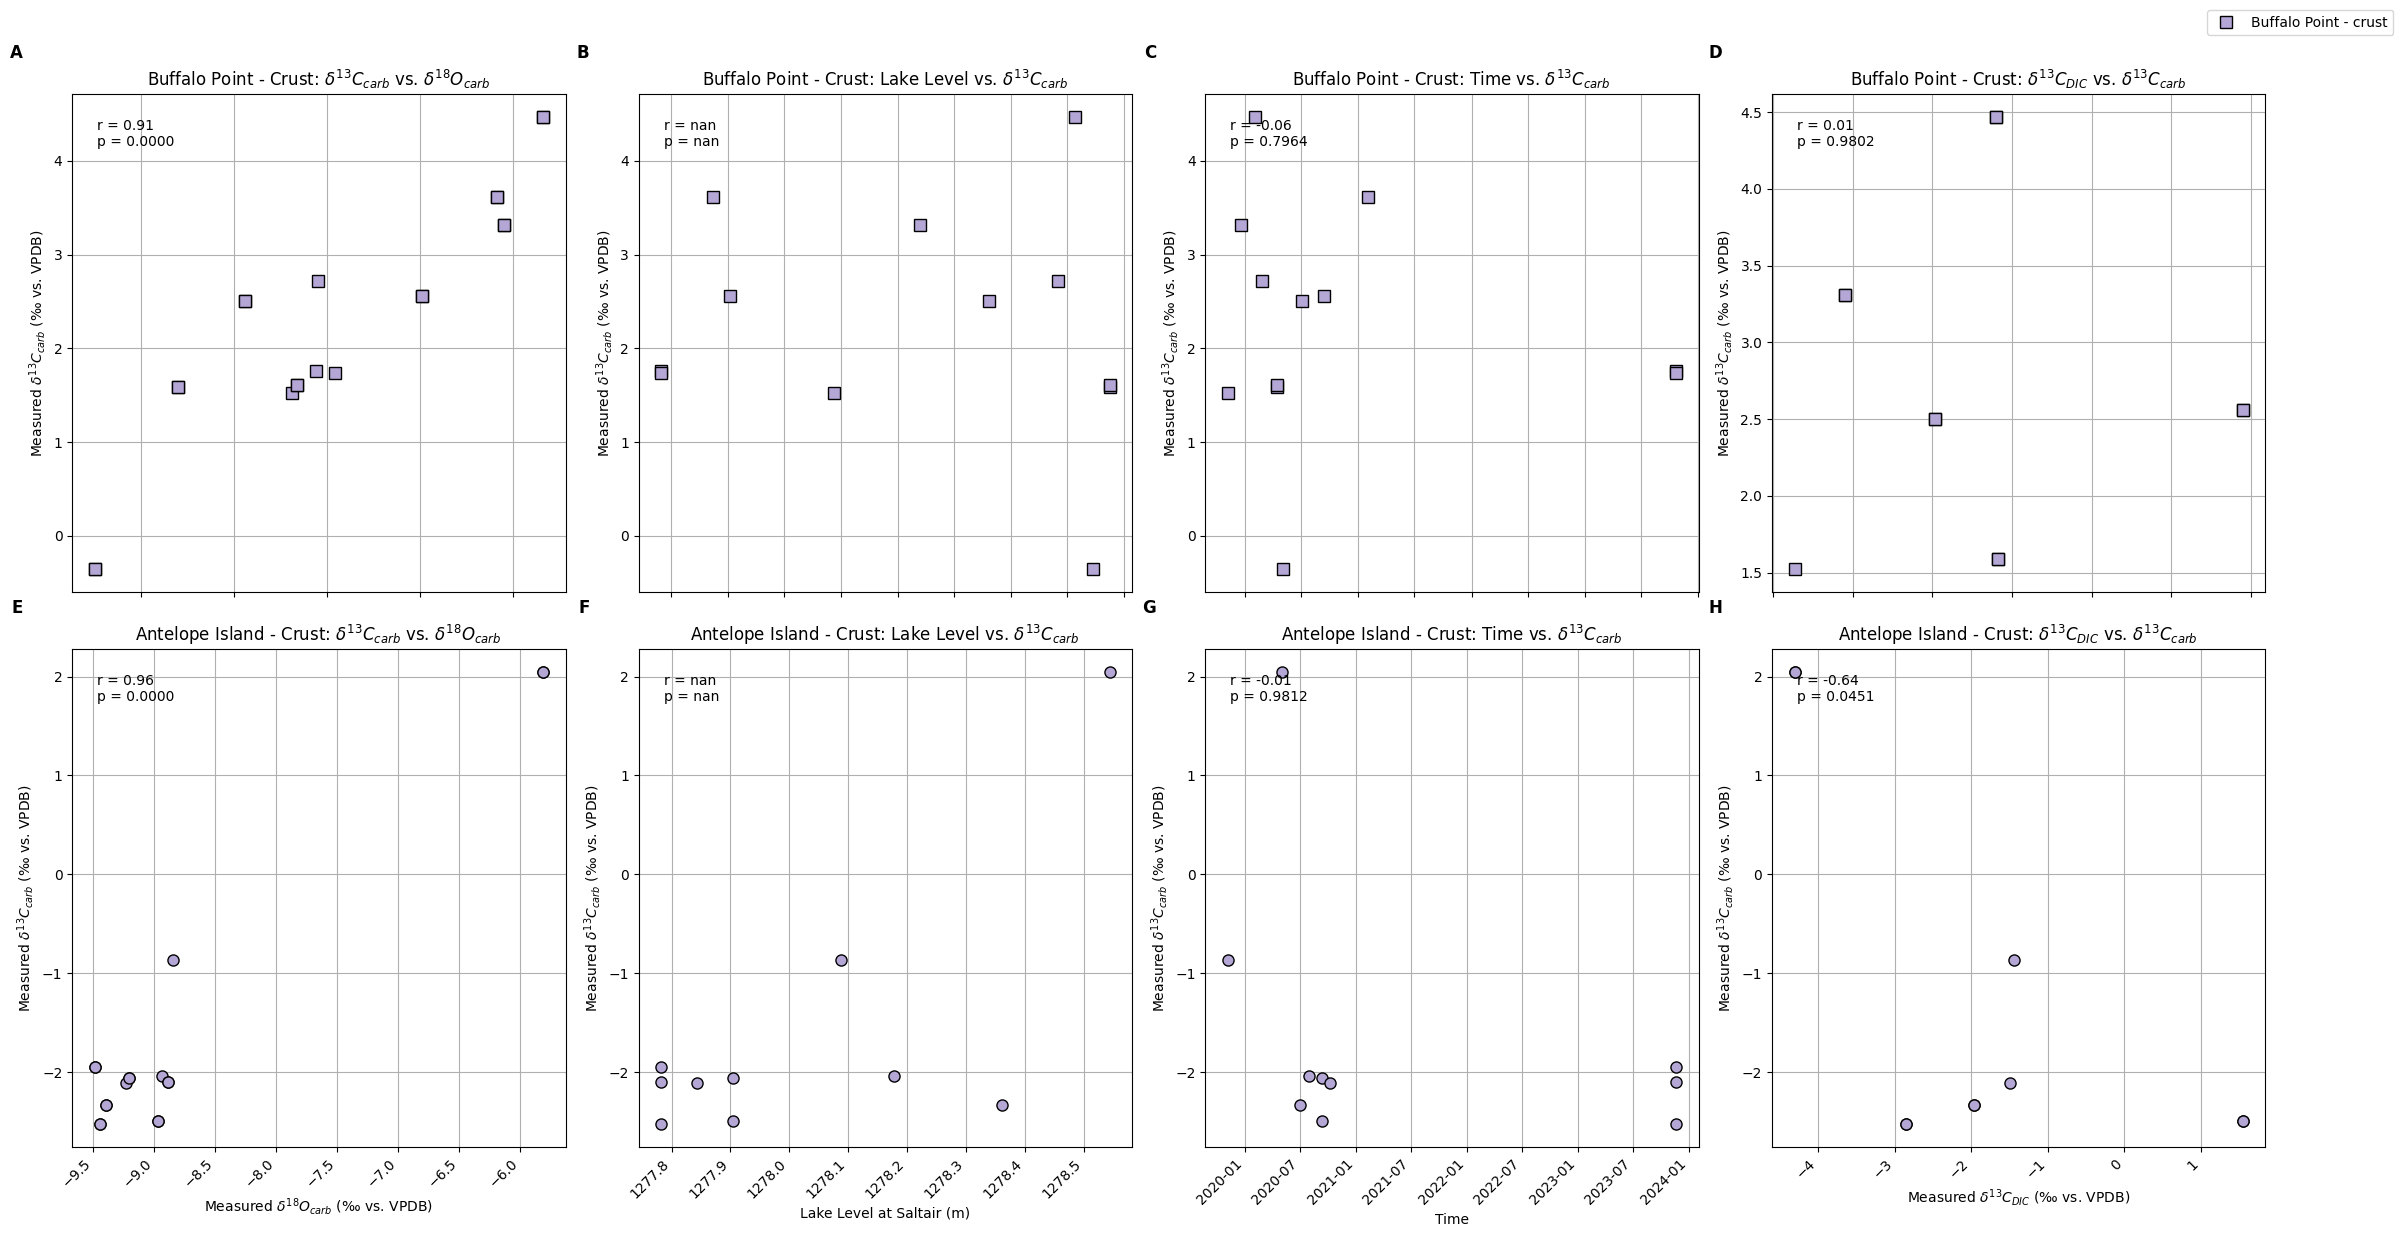

In [ ]:
import numpy as np
import string # Import the string module

# Filter the merged_gsl_data DataFrame for the first plot
filtered_data = merged_gsl_data[
    (merged_gsl_data['Site'] == 'Buffalo Point') &
    (merged_gsl_data['carb_type'] == 'crust')
].dropna(subset=['d13C_carb', 'd18O_carb'])

filtered_data_plot4 = merged_gsl_data[
    (merged_gsl_data['Site'] == 'Buffalo Point') &
    (merged_gsl_data['carb_type'] == 'crust')
 ].dropna(subset=['d13C_carb','d13C_DIC'] )

filtered_data_plot567 = merged_gsl_data[
    (merged_gsl_data['Site'] == 'Antelope Island Causeway') & # Corrected site name
    (merged_gsl_data['carb_type'] == 'crust')
].dropna(subset=['d13C_carb', 'd18O_carb'])

filtered_data_plot8 = merged_gsl_data[
    (merged_gsl_data['Site'] == 'Antelope Island Causeway') & # Corrected site name
    (merged_gsl_data['carb_type'] == 'crust')
 ].dropna(subset=['d13C_carb','d13C_DIC'] )

# Create a figure with four subplots side-by-side
fig, axs = plt.subplots(2, 4, figsize=(24, 12)) # Adjusted figsize for 2 rows

# Define markers and colors for sample data based on 'Site' and 'carb_type'
site_markers = {'Ladyfinger Point': 'D', 'Buffalo Point': 's', 'Antelope Island Causeway': 'o'}
carb_colors = {'bulk microbial boundstone': '#93c47d', 'crust': '#b4a7d6', 'white intraclast': '#ece9c9', 'bulk mud': '#351c75', 'grain coating': '#a64d79'}

# Generate alphabetical labels for 4 rows of panels
labels = list(string.ascii_uppercase)[:8] # 2 rows * 4 columns = 8 labels

##BUFFALO POINT PLOTS##
# Plot the first panel (d18O_carb vs d13C_carb for Buffalo Point - crust)
# Row 0, Column 0
ax = axs[0, 0]
for site, marker in site_markers.items():
    for carb_type, color in carb_colors.items():
        subset = filtered_data[(filtered_data['Site'] == site) & (filtered_data['carb_type'] == carb_type)]
        if not subset.empty:
            ax.plot(subset['d18O_carb'],subset['d13C_carb'], marker=marker, linestyle='', color=color, markeredgecolor='k', label=f'{site} - {carb_type}', markersize=8)

ax.set_xlabel(r'Measured $\delta^{18}O_{carb}$ (‰ vs. VPDB)')
ax.set_ylabel(r'Measured $\delta^{13}C_{carb}$ (‰ vs. VPDB)')
ax.set_title(r'Buffalo Point - Crust: $\delta^{13}C_{carb}$ vs. $\delta^{18}O_{carb}$')
ax.grid(True)

# Calculate and display correlation coefficient and p-value for plot 1
if not filtered_data.empty and filtered_data['d18O_carb'].nunique() > 1 and filtered_data['d13C_carb'].nunique() > 1:
    corr_plot1, p_value_plot1 = pearsonr(filtered_data['d18O_carb'], filtered_data['d13C_carb'])
    ax.text(0.05, 0.95, f'r = {corr_plot1:.2f}\np = {p_value_plot1:.4f}', transform=ax.transAxes, ha='left', va='top')
elif not filtered_data.empty:
    ax.text(0.05, 0.95, 'Correlation not defined', transform=ax.transAxes, ha='left', va='top')

# Plot the second panel (Lake level vs d13C_carb for Buffalo Point - crust)
# Row 0, Column 1
ax = axs[0, 1]
for site, marker in site_markers.items():
    for carb_type, color in carb_colors.items():
        subset = filtered_data[(filtered_data['Site'] == site) & (filtered_data['carb_type'] == carb_type)]
        if not subset.empty:
            ax.plot(subset['Elev_m'], subset['d13C_carb'], marker=marker, linestyle='', color=color, markeredgecolor='k', markersize=8)

ax.set_xlabel('Lake Level at Saltair (m)')
ax.set_ylabel(r'Measured $\delta^{13}C_{carb}$ (‰ vs. VPDB)')
ax.set_title(r'Buffalo Point - Crust: Lake Level vs. $\delta^{13}C_{carb}$ ')
ax.grid(True)

# Calculate and display correlation coefficient and p-value for plot 2
if not filtered_data.empty and filtered_data['Elev_m'].nunique() > 1 and filtered_data['d13C_carb'].nunique() > 1:
    corr_plot2, p_value_plot2 = pearsonr(filtered_data['Elev_m'], filtered_data['d13C_carb'])
    ax.text(0.05, 0.95, f'r = {corr_plot2:.2f}\np = {p_value_plot2:.4f}', transform=ax.transAxes, ha='left', va='top')
elif not filtered_data.empty:
     ax.text(0.05, 0.95, 'Correlation not defined\n(constant input)', transform=ax.transAxes, ha='left', va='top')

# Plot the third panel (time vs d13C_carb for Buffalo Point - crust)
# Row 0, Column 2
ax = axs[0, 2]
for site, marker in site_markers.items():
    for carb_type, color in carb_colors.items():
        subset = filtered_data[(filtered_data['Site'] == site) & (filtered_data['carb_type'] == carb_type)]
        if not subset.empty:
            ax.plot(subset['time'], subset['d13C_carb'], marker=marker, linestyle='', color=color, markeredgecolor='k', markersize=8)

ax.set_xlabel('Time')
ax.set_ylabel(r'Measured $\delta^{13}C_{carb}$ (‰ vs. VPDB)') # Corrected label
ax.set_title(r'Buffalo Point - Crust: Time vs. $\delta^{13}C_{carb}$ ')
ax.grid(True)

# Rotate x-axis labels on the third panel
fig.autofmt_xdate(rotation=45)

# Calculate and display correlation coefficient and p-value for plot 3 (Time vs d13C_carb)
if not filtered_data.empty:
    # For time correlation, convert datetime to a numerical representation (e.g., Unix timestamp)
    time_numeric = filtered_data['time'].astype(int) // 10**9 # Convert nanoseconds to seconds
    corr_plot3, p_value_plot3 = pearsonr(time_numeric, filtered_data['d13C_carb'])
    ax.text(0.05, 0.95, f'r = {corr_plot3:.2f}\np = {p_value_plot3:.4f}', transform=ax.transAxes, ha='left', va='top')

# Plot the fourth panel (d13C_DIC vs d13C_carb for Buffalo Point - crust)
# Row 0, Column 3
ax = axs[0, 3]
for site, marker in site_markers.items():
    for carb_type, color in carb_colors.items():
        subset = filtered_data_plot4[(filtered_data_plot4['Site'] == site) & (filtered_data_plot4['carb_type'] == carb_type)]
        if not subset.empty:
            ax.plot(subset['d13C_DIC'], subset['d13C_carb'], marker=marker, linestyle='', color=color, markeredgecolor='k', markersize=8)

ax.set_xlabel(r'Measured $\delta^{13}C_{DIC}$ (‰ vs. VPDB)')
ax.set_ylabel(r'Measured $\delta^{13}C_{carb}$ (‰ vs. VPDB)')
ax.set_title(r'Buffalo Point - Crust: $\delta^{13}C_{DIC}$ vs. $\delta^{13}C_{carb}$ ')
ax.grid(True)

# Calculate and display correlation coefficient and p-value for plot 4 (d13C_DIC vs d13C_carb)
if not filtered_data_plot4.empty and filtered_data_plot4['d13C_DIC'].nunique() > 1 and filtered_data_plot4['d13C_carb'].nunique() > 1:
    corr_plot4, p_value_plot4 = pearsonr(filtered_data_plot4['d13C_DIC'], filtered_data_plot4['d13C_carb'])
    ax.text(0.05, 0.95, f'r = {corr_plot4:.2f}\np = {p_value_plot4:.4f}', transform=ax.transAxes, ha='left', va='top')
elif not filtered_data_plot4.empty:
     ax.text(0.05, 0.95, 'Correlation not defined', transform=ax.transAxes, ha='left', va='top')

##ANTELOPE ISLAND PLOTS##
# Plot the first panel (d18O_carb vs d13C_carb for Antelope Island - crust)
# Row 1, Column 0
ax = axs[1, 0]
for site, marker in site_markers.items():
    for carb_type, color in carb_colors.items():
        subset = filtered_data_plot567[(filtered_data_plot567['Site'] == site) & (filtered_data_plot567['carb_type'] == carb_type)]
        if not subset.empty:
            ax.plot(subset['d18O_carb'],subset['d13C_carb'], marker=marker, linestyle='', color=color, markeredgecolor='k', label=f'{site} - {carb_type}', markersize=8)

ax.set_xlabel(r'Measured $\delta^{18}O_{carb}$ (‰ vs. VPDB)')
ax.set_ylabel(r'Measured $\delta^{13}C_{carb}$ (‰ vs. VPDB)')
ax.set_title(r'Antelope Island - Crust: $\delta^{13}C_{carb}$ vs. $\delta^{18}O_{carb}$ ')
ax.grid(True)

# Calculate and display correlation coefficient and p-value for plot 5
if not filtered_data_plot567.empty and filtered_data_plot567['d18O_carb'].nunique() > 1 and filtered_data_plot567['d13C_carb'].nunique() > 1:
    corr_plot5, p_value_plot5 = pearsonr(filtered_data_plot567['d18O_carb'], filtered_data_plot567['d13C_carb'])
    ax.text(0.05, 0.95, f'r = {corr_plot5:.2f}\np = {p_value_plot5:.4f}', transform=ax.transAxes, ha='left', va='top')
elif not filtered_data_plot567.empty:
    ax.text(0.05, 0.95, 'Correlation not defined', transform=ax.transAxes, ha='left', va='top')

# Plot the second panel (Lake level vs d13C_carb for Antelope Island - crust)
# Row 1, Column 1
ax = axs[1, 1]
for site, marker in site_markers.items():
    for carb_type, color in carb_colors.items():
        subset = filtered_data_plot567[(filtered_data_plot567['Site'] == site) & (filtered_data_plot567['carb_type'] == carb_type)]
        if not subset.empty:
            ax.plot(subset['Elev_m'], subset['d13C_carb'], marker=marker, linestyle='', color=color, markeredgecolor='k', markersize=8)

ax.set_xlabel('Lake Level at Saltair (m)')
ax.set_ylabel(r'Measured $\delta^{13}C_{carb}$ (‰ vs. VPDB)')
ax.set_title(r'Antelope Island - Crust: Lake Level vs. $\delta^{13}C_{carb}$ ')
ax.grid(True)

# Calculate and display correlation coefficient and p-value for plot 6
if not filtered_data_plot567.empty and filtered_data_plot567['Elev_m'].nunique() > 1 and filtered_data_plot567['d13C_carb'].nunique() > 1:
    corr_plot6, p_value_plot6 = pearsonr(filtered_data_plot567['Elev_m'], filtered_data_plot567['d13C_carb']) # Corrected filtered data
    ax.text(0.05, 0.95, f'r = {corr_plot6:.2f}\np = {p_value_plot6:.4f}', transform=ax.transAxes, ha='left', va='top')
elif not filtered_data_plot567.empty:
     ax.text(0.05, 0.95, 'Correlation not defined\n(constant input)', transform=ax.transAxes, ha='left', va='top')

# Plot the third panel (time vs d13C_carb for Antelope Island - crust)
# Row 1, Column 2
ax = axs[1, 2]
for site, marker in site_markers.items():
    for carb_type, color in carb_colors.items():
        subset = filtered_data_plot567[(filtered_data_plot567['Site'] == site) & (filtered_data_plot567['carb_type'] == carb_type)]
        if not subset.empty:
            ax.plot(subset['time'], subset['d13C_carb'], marker=marker, linestyle='', color=color, markeredgecolor='k', markersize=8)

ax.set_xlabel('Time')
ax.set_ylabel(r'Measured $\delta^{13}C_{carb}$ (‰ vs. VPDB)') # Corrected label
ax.set_title(r'Antelope Island - Crust: Time vs. $\delta^{13}C_{carb}$ ')
ax.grid(True)

# Rotate x-axis labels on the third panel
fig.autofmt_xdate(rotation=45)

# Calculate and display correlation coefficient and p-value for plot 7 (Time vs d13C_carb)
if not filtered_data_plot567.empty:
    # For time correlation, convert datetime to a numerical representation (e.g., Unix timestamp)
    time_numeric = filtered_data_plot567['time'].astype(int) // 10**9 # Convert nanoseconds to seconds
    corr_plot7, p_value_plot7 = pearsonr(time_numeric, filtered_data_plot567['d13C_carb'])
    ax.text(0.05, 0.95, f'r = {corr_plot7:.2f}\np = {p_value_plot7:.4f}', transform=ax.transAxes, ha='left', va='top')

# Plot the fourth panel (d13C_DIC vs d13C_carb for Antelope Island - crust)
# Row 1, Column 3
ax = axs[1, 3]
for site, marker in site_markers.items():
    for carb_type, color in carb_colors.items():
        subset = filtered_data_plot8[(filtered_data_plot8['Site'] == site) & (filtered_data_plot8['carb_type'] == carb_type)]
        if not subset.empty:
            ax.plot(subset['d13C_DIC'], subset['d13C_carb'], marker=marker, linestyle='', color=color, markeredgecolor='k', markersize=8)

ax.set_xlabel(r'Measured $\delta^{13}C_{DIC}$ (‰ vs. VPDB)')
ax.set_ylabel(r'Measured $\delta^{13}C_{carb}$ (‰ vs. VPDB)')
ax.set_title(r'Antelope Island - Crust: $\delta^{13}C_{DIC}$ vs. $\delta^{13}C_{carb}$ ')
ax.grid(True)

# Calculate and display correlation coefficient and p-value for plot 8 (d13C_DIC vs d13C_carb)
if not filtered_data_plot8.empty and filtered_data_plot8['d13C_DIC'].nunique() > 1 and filtered_data_plot8['d13C_carb'].nunique() > 1:
    corr_plot8, p_value_plot8 = pearsonr(filtered_data_plot8['d13C_DIC'], filtered_data_plot8['d13C_carb'])
    ax.text(0.05, 0.95, f'r = {corr_plot8:.2f}\np = {p_value_plot8:.4f}', transform=ax.transAxes, ha='left', va='top')
elif not filtered_data_plot8.empty:
    ax.text(0.05, 0.95, 'Correlation not defined', transform=ax.transAxes, ha='left', va='top')


# Add alphabetical panel labels
for i, ax in enumerate(axs.flat):
    ax.text(-0.1, 1.1, labels[i], transform=ax.transAxes,
                   fontsize=12, fontweight='bold', va='top', ha='right')

# Add a single legend for all plots
handles, labels = axs[0,0].get_legend_handles_labels() # Get handles/labels from one of the subplots
fig.legend(handles, labels, loc='lower right', bbox_to_anchor=(1.0, 1.0))

plt.tight_layout(rect=[0, 0, 0.95, 1]) # Adjust layout to make space for legend
plt.show()
fig.savefig('correlations_d13C_crusts.pdf', bbox_inches='tight')

In [ ]:
filtered_data = merged_gsl_data.dropna(subset=['d13C_carb', 'Elev_m'])
grouped_data = filtered_data.groupby(['Site', 'carb_type'])

for group_name, group_data in grouped_data:
    site, carb_type = group_name

    # Ensure there are enough data points to perform correlation calculation
    if len(group_data) > 1 and group_data['Elev_m'].nunique() > 1 and group_data['d13C_carb'].nunique() > 1:
        # Calculate Pearson correlation coefficient and p-value
        corr, p_value = pearsonr(group_data['Elev_m'], group_data['d13C_carb'])
        # Calculate R-squared
        r_squared = corr**2

        print(f'Group: {site} - {carb_type}')
        print(f'  Pearson r: {corr:.4f}')
        print(f'  R-squared: {r_squared:.4f}')
        print(f'  P-value: {p_value:.4f}')
        print("-" * 20)
    else:
        print(f'Group: {site} - {carb_type}')
        print('  Not enough data points or constant values to calculate correlation.')
        print("-" * 20)

Group: Antelope Island Causeway - bulk mud
  Pearson r: -0.3251
  R-squared: 0.1057
  P-value: 0.3933
--------------------
Group: Antelope Island Causeway - crust
  Pearson r: 0.6949
  R-squared: 0.4829
  P-value: 0.0257
--------------------
Group: Buffalo Point - bulk microbial boundstone
  Pearson r: -0.3099
  R-squared: 0.0960
  P-value: 0.1019
--------------------
Group: Buffalo Point - crust
  Pearson r: -0.1153
  R-squared: 0.0133
  P-value: 0.7213
--------------------
Group: Buffalo Point - grain coating
  Not enough data points or constant values to calculate correlation.
--------------------
Group: Buffalo Point - white intraclast
  Pearson r: 0.4775
  R-squared: 0.2280
  P-value: 0.1629
--------------------
Group: Ladyfinger Point - bulk microbial boundstone
  Pearson r: -0.6534
  R-squared: 0.4269
  P-value: 0.2318
--------------------


# Assess a linear correlation between lake level and d13Ccarb and d18Ocarb for each site and facies.

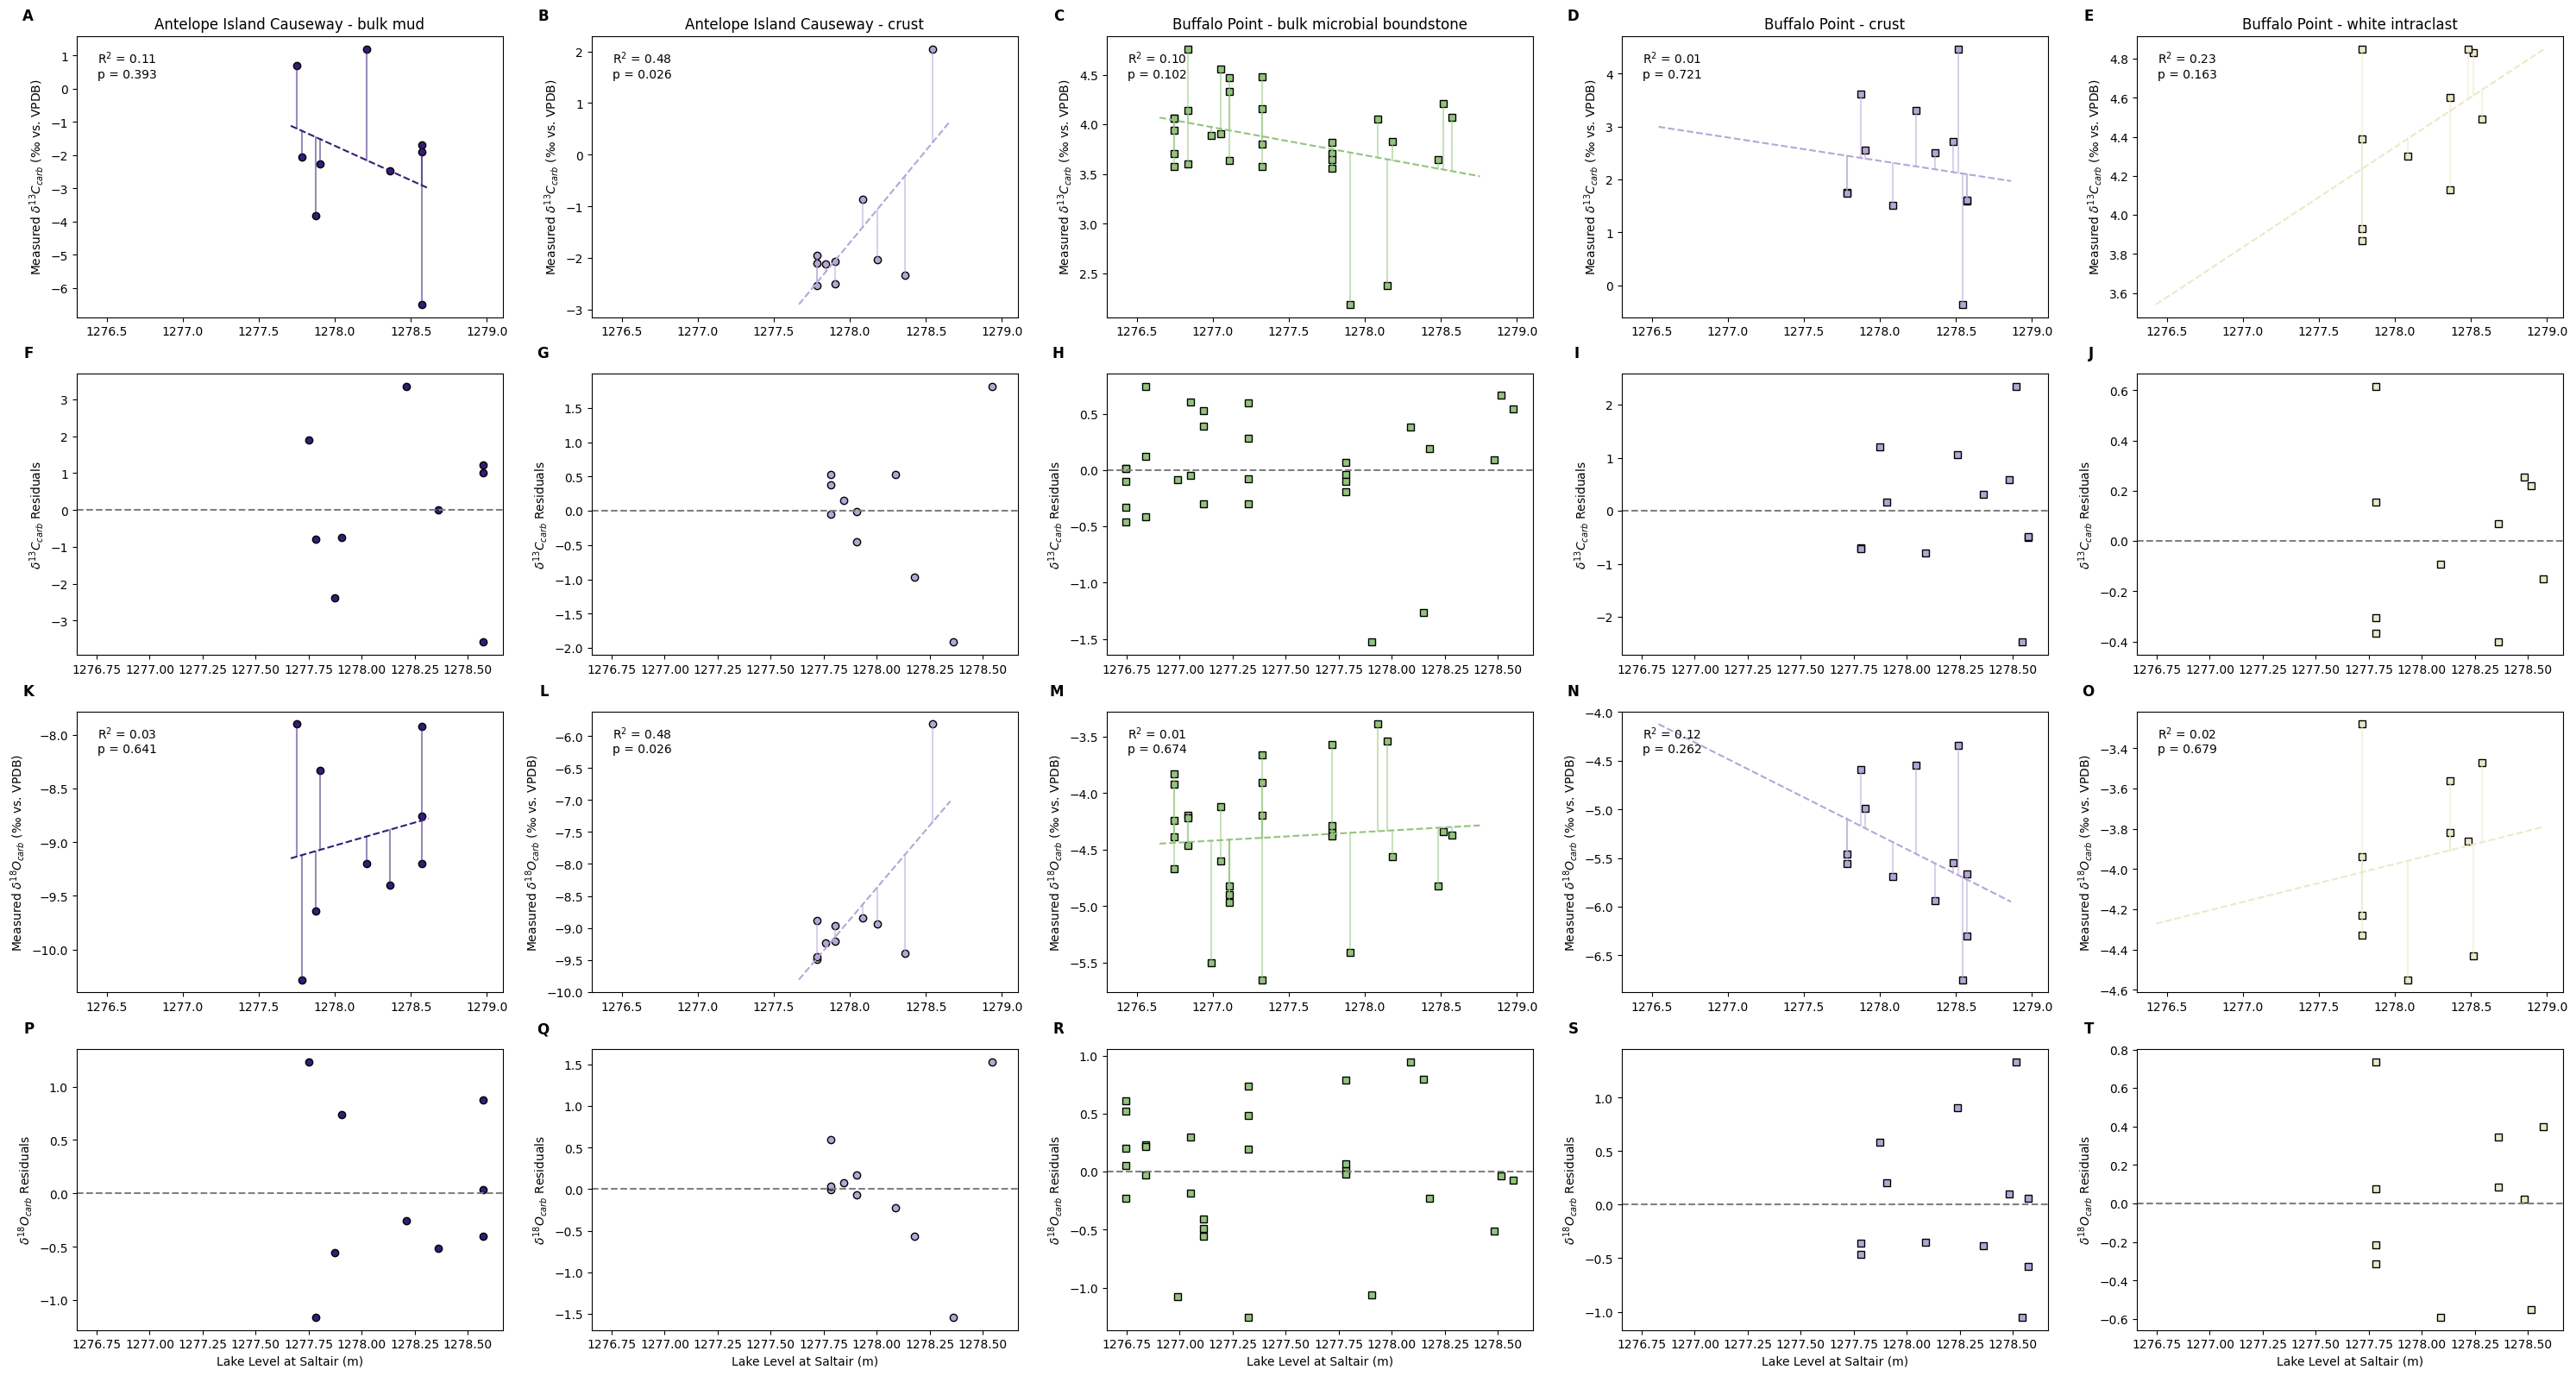

In [ ]:
from scipy.stats import linregress
import string

# Filter out 'grain coating' carb_type and 'Ladyfinger Point' site
filtered_groups = [(name, data) for name, data in grouped_data if name[1] != 'grain coating' and name[0] != 'Ladyfinger Point']

# Create a figure with two sets of panels for d13C_carb and two for d18O_carb
fig, axs = plt.subplots(4, len(filtered_groups), figsize=(6 * len(filtered_groups), 16), sharex='row')

# Ensure axs is always a 2D array
if len(filtered_groups) == 1:
    axs = np.array([axs]).T

# Define markers for each site
site_markers = {'Ladyfinger Point': 'D', 'Buffalo Point': 's', 'Antelope Island Causeway': 'o'}
# Define colors for each carb_type
carb_colors = {'bulk microbial boundstone': '#93c47d', 'crust': '#b4a7d6', 'white intraclast': '#ece9c9', 'bulk mud': '#351c75', 'grain coating': '#a64d79'}

# Generate alphabetical labels for 4 rows of panels
labels = list(string.ascii_uppercase)[:4 * len(filtered_groups)]

for i, (group_name, group_data) in enumerate(filtered_groups):
    site, carb_type = group_name

    # --- d13C_carb plots ---
    # Plot Elev_m vs d13C_carb
    temp_handle, = axs[0, i].plot(group_data['Elev_m'], group_data['d13C_carb'],
                                  marker=site_markers.get(site, 'x'),
                                  linestyle='',
                                  color=carb_colors.get(carb_type, 'black'),
                                  label=f'{site} - {carb_type}',
                                  markeredgecolor='k')

    # Perform linear regression for d13C_carb
    if len(group_data) > 1 and group_data['Elev_m'].nunique() > 1 and group_data['d13C_carb'].nunique() > 1:
        slope_c13, intercept_c13, r_value_c13, p_value_c13, std_err_c13 = linregress(group_data['Elev_m'], group_data['d13C_carb'])

        # Plot the regression line for d13C_carb
        x_vals = np.array(axs[0, i].get_xlim())
        y_vals_c13 = intercept_c13 + slope_c13 * x_vals
        axs[0, i].plot(x_vals, y_vals_c13, color=carb_colors.get(carb_type, 'black'), linestyle='--')

        # Calculate residuals for d13C_carb
        predicted_d13C_carb = intercept_c13 + slope_c13 * group_data['Elev_m']
        residuals_c13 = group_data['d13C_carb'] - predicted_d13C_carb

        # Plot vertical lines for residuals for d13C_carb
        for x, y_actual, y_predicted in zip(group_data['Elev_m'], group_data['d13C_carb'], predicted_d13C_carb):
            axs[0, i].plot([x, x], [y_actual, y_predicted], color=carb_colors.get(carb_type, 'black'), linestyle='-', alpha=0.5)

        # Plot residuals vs Elev_m for d13C_carb
        axs[1, i].plot(group_data['Elev_m'], residuals_c13,
                       marker=site_markers.get(site, 'x'),
                       linestyle='',
                       color=carb_colors.get(carb_type, 'black'),
                       markeredgecolor='k')

        # Add R-squared and p-value as text annotations in the top panel for d13C_carb
        r_squared_c13 = r_value_c13**2
        axs[0, i].text(0.05, 0.95, f'R$^2$ = {r_squared_c13:.2f}\np = {p_value_c13:.3f}', transform=axs[0, i].transAxes, ha='left', va='top')
    else:
        axs[0, i].text(0.05, 0.95, 'Not enough data', transform=axs[0, i].transAxes, ha='left', va='top')
        axs[1, i].text(0.05, 0.95, 'Not enough data', transform=axs[1, i].transAxes, ha='left', va='top')

    # Add a horizontal dashed line at y=0 in the residuals plot for d13C_carb
    axs[1, i].axhline(0, color='gray', linestyle='--')

    # Set labels for d13C_carb plots
    axs[0, i].set_title(f'{site} - {carb_type}')
    axs[0, i].set_ylabel(r'Measured $\delta^{13}C_{carb}$ (‰ vs. VPDB)')
    axs[1, i].set_ylabel(r'$\delta^{13}C_{carb}$ Residuals')

    # --- d18O_carb plots ---
    # Plot Elev_m vs d18O_carb
    axs[2, i].plot(group_data['Elev_m'], group_data['d18O_carb'],
                   marker=site_markers.get(site, 'x'),
                   linestyle='',
                   color=carb_colors.get(carb_type, 'black'),
                   markeredgecolor='k')

    # Perform linear regression for d18O_carb
    if len(group_data) > 1 and group_data['Elev_m'].nunique() > 1 and group_data['d18O_carb'].nunique() > 1:
        slope_o18, intercept_o18, r_value_o18, p_value_o18, std_err_o18 = linregress(group_data['Elev_m'].dropna(), group_data['d18O_carb'].dropna())

        # Plot the regression line for d18O_carb
        x_vals = np.array(axs[2, i].get_xlim())
        y_vals_o18 = intercept_o18 + slope_o18 * x_vals
        axs[2, i].plot(x_vals, y_vals_o18, color=carb_colors.get(carb_type, 'black'), linestyle='--')

        # Calculate residuals for d18O_carb
        predicted_d18O_carb = intercept_o18 + slope_o18 * group_data['Elev_m'].dropna()
        residuals_o18 = group_data['d18O_carb'].dropna() - predicted_d18O_carb

        # Plot vertical lines for residuals for d18O_carb
        for x, y_actual, y_predicted in zip(group_data['Elev_m'].dropna(), group_data['d18O_carb'].dropna(), predicted_d18O_carb):
            axs[2, i].plot([x, x], [y_actual, y_predicted], color=carb_colors.get(carb_type, 'black'), linestyle='-', alpha=0.5)

        # Plot residuals vs Elev_m for d18O_carb
        axs[3, i].plot(group_data['Elev_m'].dropna(), residuals_o18,
                       marker=site_markers.get(site, 'x'),
                       linestyle='',
                       color=carb_colors.get(carb_type, 'black'),
                       markeredgecolor='k')

        # Add R-squared and p-value as text annotations in the top panel for d18O_carb
        r_squared_o18 = r_value_o18**2
        axs[2, i].text(0.05, 0.95, f'R$^2$ = {r_squared_o18:.2f}\np = {p_value_o18:.3f}', transform=axs[2, i].transAxes, ha='left', va='top')

    else:
        axs[2, i].text(0.05, 0.95, 'Not enough data', transform=axs[2, i].transAxes, ha='left', va='top')
        axs[3, i].text(0.05, 0.95, 'Not enough data', transform=axs[3, i].transAxes, ha='left', va='top')


    # Add a horizontal dashed line at y=0 in the residuals plot for d18O_carb
    axs[3, i].axhline(0, color='gray', linestyle='--')

    # Set labels for d18O_carb plots
    axs[2, i].set_ylabel(r'Measured $\delta^{18}O_{carb}$ (‰ vs. VPDB)')
    axs[3, i].set_ylabel(r'$\delta^{18}O_{carb}$ Residuals')
    axs[3, i].set_xlabel('Lake Level at Saltair (m)') # Only set xlabel on the bottom row

    # Add alphabetical panel labels
    axs[0, i].text(-0.1, 1.1, labels[i], transform=axs[0, i].transAxes,
                   fontsize=12, fontweight='bold', va='top', ha='right')
    axs[1, i].text(-0.1, 1.1, labels[i + len(filtered_groups)], transform=axs[1, i].transAxes,
                   fontsize=12, fontweight='bold', va='top', ha='right')
    axs[2, i].text(-0.1, 1.1, labels[i + 2*len(filtered_groups)], transform=axs[2, i].transAxes,
                   fontsize=12, fontweight='bold', va='top', ha='right')
    axs[3, i].text(-0.1, 1.1, labels[i + 3*len(filtered_groups)], transform=axs[3, i].transAxes,
                   fontsize=12, fontweight='bold', va='top', ha='right')

# Adjust layout and display the plot
fig.tight_layout()
plt.show()
fig.savefig('elev_vs_d13C_d18O_carb.pdf', bbox_inches='tight')

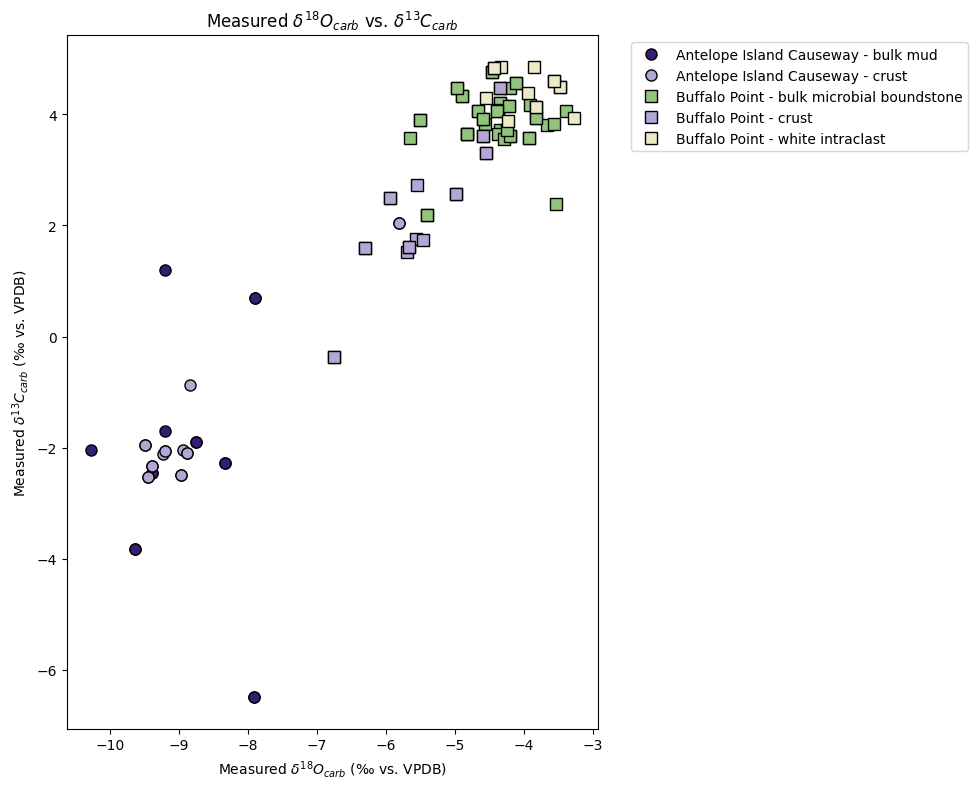

In [ ]:
filtered_data_for_crossplot = merged_gsl_data.dropna(subset=['d13C_carb', 'd18O_carb']).copy()
filtered_data_for_crossplot = filtered_data_for_crossplot[
    (filtered_data_for_crossplot['carb_type'] != 'grain coating') &
    (filtered_data_for_crossplot['Site'] != 'Ladyfinger Point')
]

fig, ax = plt.subplots(figsize=(10, 8))

site_markers = {'Ladyfinger Point': 'D', 'Buffalo Point': 's', 'Antelope Island Causeway': 'o'}
carb_colors = {'bulk microbial boundstone': '#93c47d', 'crust': '#b4a7d6', 'white intraclast': '#ece9c9', 'bulk mud': '#351c75', 'grain coating': '#a64d79'}

for (site, carb_type), subset in filtered_data_for_crossplot.groupby(['Site', 'carb_type']):
    ax.plot(subset['d18O_carb'], subset['d13C_carb'],
            marker=site_markers.get(site, 'x'),
            color=carb_colors.get(carb_type, 'black'),
            linestyle='',
            label=f'{site} - {carb_type}',
            markeredgecolor='k',
            markersize=8)

ax.set_ylabel(r'Measured $\delta^{13}C_{carb}$ (‰ vs. VPDB)')
ax.set_xlabel(r'Measured $\delta^{18}O_{carb}$ (‰ vs. VPDB)')
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.title(r'Measured $\delta^{18}O_{carb}$ vs. $\delta^{13}C_{carb}$')
fig.tight_layout()
plt.show()

fig.savefig('d18O_vs_d13C_carb_scatter.pdf', bbox_inches='tight')

  Buffalo Point - bulk microbial boundstone: r = 0.1441, p = 0.3393
  Buffalo Point - crust: r = 0.9083, p = 0.0000
  Buffalo Point - white intraclast: r = -0.2736, p = 0.3439
  Antelope Island Causeway - crust+bulk mud (combined): r = 0.4360, p = 0.0126
--------------------


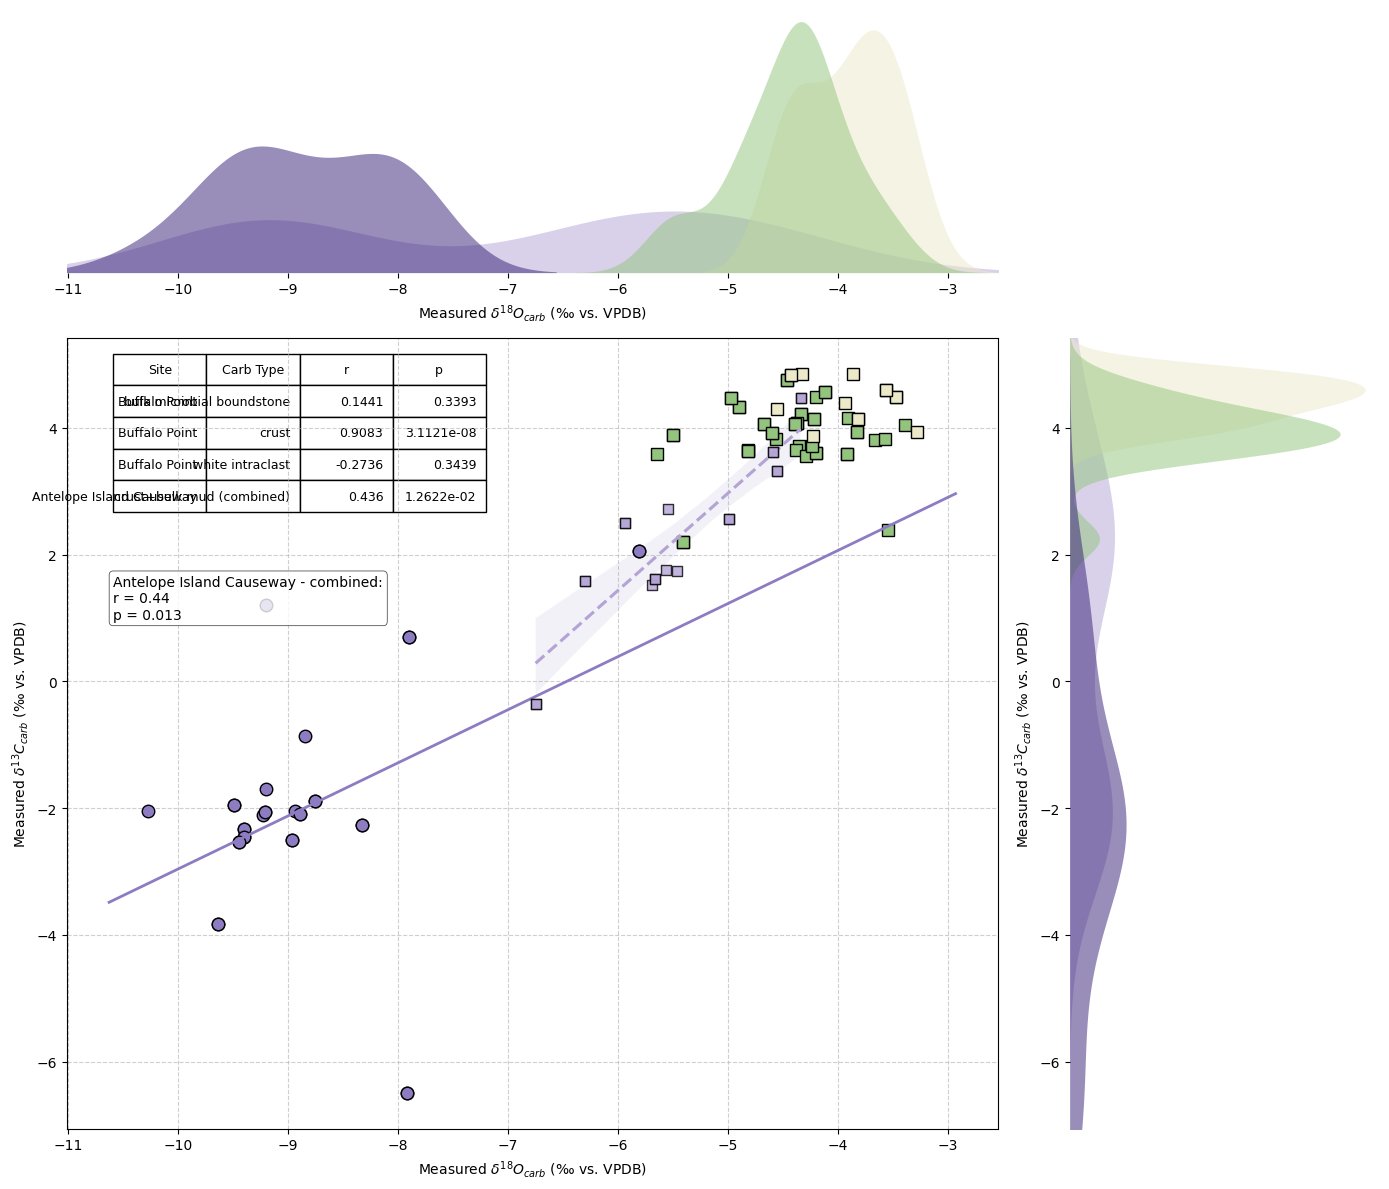

In [ ]:
from scipy.stats import linregress, pearsonr
import seaborn as sns
import numpy as np
import pandas as pd # Import pandas for creating the table

# Create a copy to work with for this cell's filtering
filtered_data_for_analysis = filtered_data_for_crossplot.copy()

# --- Prepare data for individual and combined plotting/stats ---

# Data for Antelope Island combined muds and crusts because of no statistically significant differences in their d13C and d18O carbonate values (below).
antelope_island_combined_mask = (filtered_data_for_analysis['Site'] == 'Antelope Island Causeway') & \
                                (filtered_data_for_analysis['carb_type'].isin(['crust', 'bulk mud']))
antelope_island_combined_df = filtered_data_for_analysis[antelope_island_combined_mask].copy()

# Calculate statistics for the combined Antelope Island group (WITH all data)
corr_ai_combined, p_value_ai_combined = np.nan, np.nan
slope_ai_combined, intercept_ai_combined, r_value_ai_combined, p_value_ai_combined_reg, std_err_ai_combined = (np.nan,)*5

if len(antelope_island_combined_df) > 1 and \
   antelope_island_combined_df['d13C_carb'].nunique() > 1 and \
   antelope_island_combined_df['d18O_carb'].nunique() > 1:
    corr_ai_combined, p_value_ai_combined = pearsonr(antelope_island_combined_df['d13C_carb'], antelope_island_combined_df['d18O_carb'])
    # Using linregress for regression line
    slope_ai_combined, intercept_ai_combined, r_value_ai_combined, p_value_ai_combined_reg, std_err_ai_combined = \
        linregress(antelope_island_combined_df['d18O_carb'], antelope_island_combined_df['d13C_carb']) # Swapped x and y for linregress arguments

# Calculate correlation coefficients and store in a list for the table
correlation_data = []

# Process Buffalo Point groups (individual)
buffalo_point_groups = filtered_data_for_analysis[filtered_data_for_analysis['Site'] == 'Buffalo Point'].groupby(['Site', 'carb_type'])
for group_name, group_data in buffalo_point_groups:
    site, carb_type = group_name
    if len(group_data) > 1 and group_data['d13C_carb'].nunique() > 1 and group_data['d18O_carb'].nunique() > 1:
        corr, p_value = pearsonr(group_data['d13C_carb'], group_data['d18O_carb'])
        correlation_data.append({'Site': site, 'Carb Type': carb_type, 'r': corr, 'p': p_value})
        print(f'  {site} - {carb_type}: r = {corr:.4f}, p = {p_value:.4f}')
    else:
        correlation_data.append({'Site': site, 'Carb Type': carb_type, 'r': np.nan, 'p': np.nan})
        print(f'  Not enough data to calculate correlation for {site} - {carb_type}')

# Add the combined Antelope Island group to the correlation data
correlation_data.append({'Site': 'Antelope Island Causeway', 'Carb Type': 'crust+bulk mud (combined)', 'r': corr_ai_combined, 'p': p_value_ai_combined})
print(f"  Antelope Island Causeway - crust+bulk mud (combined): r = {corr_ai_combined:.4f}, p = {p_value_ai_combined:.4f}")
print("-" * 20)

correlation_df = pd.DataFrame(correlation_data)

# Create a figure with two sets of panels for the scatter plots and ridge plots
fig, axs = plt.subplots(2, 2, figsize=(14, 12), gridspec_kw={'width_ratios': [3, 1], 'height_ratios': [1, 3]})
ax_scatter = axs[1, 0]

# Define markers and colors for plotting
site_markers = {'Buffalo Point': 's', 'Antelope Island Causeway': 'o'}
carb_colors = {
    'bulk microbial boundstone': '#93c47d',
    'crust': '#b4a4d6',
    'white intraclast': '#ece9c9',
    'bulk mud': '#351c75',
    'crust+bulk mud (combined)': '#8e7cc3' # New color for combined AI group
}

# Plot Buffalo Point data individually
buffalo_point_df = filtered_data_for_analysis[filtered_data_for_analysis['Site'] == 'Buffalo Point']
for (site, carb_type), subset in buffalo_point_df.groupby(['Site', 'carb_type']):
    marker = site_markers.get(site, 'x')
    color = carb_colors.get(carb_type, 'black')
    label = f'{site} - {carb_type}'

    if carb_type == 'crust': # Special handling for Buffalo Point crust regression
        if len(subset) > 1 and subset['d13C_carb'].nunique() > 1 and subset['d18O_carb'].nunique() > 1:
            # Recalculate slope/intercept for plotting regression line (using subset for this specific group)
            slope_bp, intercept_bp, r_value_bp, p_value_bp, _ = linregress(subset['d18O_carb'], subset['d13C_carb'])

            sns.regplot(x='d18O_carb', y='d13C_carb', data=subset, ax=ax_scatter, color=color, marker=marker, ci=95,
                        label=f'{label} (R={r_value_bp:.2f}, p={p_value_bp:.3f})',
                        scatter_kws={'s': 60, 'edgecolor': 'k', 'zorder': 5},
                        line_kws={'color': color, 'linestyle': '--', 'zorder': 4})
        else:
             ax_scatter.plot(subset['d18O_carb'], subset['d13C_carb'], marker=marker, linestyle='', color=color, markeredgecolor='k', markersize=8, label=label, zorder=2)
    else: # Other Buffalo Point carb types
        ax_scatter.plot(subset['d18O_carb'], subset['d13C_carb'], marker=marker, linestyle='', color=color, markeredgecolor='k', markersize=8, label=label, zorder=2)

# Plot combined Antelope Island data (reverting to manual scatter and line without CI)
if not antelope_island_combined_df.empty:
    combined_label = 'Antelope Island Causeway - combined'
    combined_marker = 'o' # Antelope Island original marker
    combined_color = carb_colors.get('crust+bulk mud (combined)', 'gray') # Use the new combined color
    ax_scatter.plot(antelope_island_combined_df['d18O_carb'], antelope_island_combined_df['d13C_carb'],
                    marker=combined_marker, linestyle='', color=combined_color, markeredgecolor='k', markersize=9,
                    label=combined_label, zorder=3)
    if not np.isnan(r_value_ai_combined):
        x_vals = np.array(ax_scatter.get_xlim())
        y_vals = intercept_ai_combined + slope_ai_combined * x_vals
        ax_scatter.plot(x_vals, y_vals, color=combined_color, linestyle='-', linewidth=2, zorder=4)
        stats_text = f'{combined_label}:\nr = {r_value_ai_combined:.2f}\np = {p_value_ai_combined_reg:.3f}'
        ax_scatter.text(0.05, 0.70, stats_text, transform=ax_scatter.transAxes, ha='left', va='top',
                        bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="black", lw=0.5, alpha=0.8), fontsize=10)

ax_scatter.set_xlabel(r'Measured $\delta^{18}O_{carb}$ (‰ vs. VPDB)')
ax_scatter.set_ylabel(r'Measured $\delta^{13}C_{carb}$ (‰ vs. VPDB)')
ax_scatter.grid(True, linestyle='--', alpha=0.6)

correlation_df['r'] = correlation_df['r'].round(4).astype(str)
correlation_df['p'] = correlation_df.apply(
    lambda row: f"{row['p']:.4e}" if ((row['Carb Type'] == 'crust' and row['Site'] == 'Buffalo Point') or
                                   (row['Carb Type'] == 'crust+bulk mud (combined)' and pd.notna(row['p'])))
                 else (f"{row['p']:.4f}" if pd.notna(row['p']) else ''),
    axis=1
)

table = ax_scatter.table(cellText=correlation_df[['Site', 'Carb Type', 'r', 'p']].values,
                         colLabels=['Site', 'Carb Type', 'r', 'p'],
                         loc='upper left', bbox=[0.05, 0.78, 0.4, 0.2]) # Adjusted bbox for position and size

table.auto_set_font_size(False)
table.set_fontsize(9)
table.scale(1.2, 1.2) # Adjust scale for better readability

# Ridge plot for d18O_carb
ax_ridge_o18 = axs[0, 0]
sns.kdeplot(data=filtered_data_for_analysis, x='d18O_carb', hue='carb_type', fill=True, ax=ax_ridge_o18,
            palette={'bulk microbial boundstone': '#93c47d', 'crust': '#b4a4d6', 'white intraclast': '#ece9c9', 'bulk mud': '#351c75', 'crust+bulk mud (combined)': '#8e7cc3'},
            common_norm=False, alpha=.5, linewidth=0)
ax_ridge_o18.set_xlabel(r'Measured $\delta^{18}O_{carb}$ (‰ vs. VPDB)')
ax_ridge_o18.set_ylabel('Density')
ax_ridge_o18.yaxis.set_visible(False)
ax_ridge_o18.legend([], [], frameon=False)
ax_ridge_o18.spines[['top', 'right', 'bottom', 'left']].set_visible(False)
ax_ridge_o18.set_xlim(ax_scatter.get_xlim())

# Ridge plot for d13C_carb
ax_ridge_c13 = axs[1, 1]
sns.kdeplot(data=filtered_data_for_analysis, y='d13C_carb', hue='carb_type', fill=True, ax=ax_ridge_c13,
            palette={'bulk microbial boundstone': '#93c47d', 'crust': '#b4a4d6', 'white intraclast': '#ece9c9', 'bulk mud': '#351c75', 'crust+bulk mud (combined)': '#8e7cc3'},
            common_norm=False, alpha=.5, linewidth=0)
ax_ridge_c13.set_xlabel('Density')
ax_ridge_c13.set_ylabel(r'Measured $\delta^{13}C_{carb}$ (‰ vs. VPDB)')
ax_ridge_c13.xaxis.set_visible(False)
ax_ridge_c13.legend([], [], frameon=False)
ax_ridge_c13.spines[['top', 'right', 'bottom', 'left']].set_visible(False)
ax_ridge_c13.set_ylim(ax_scatter.get_ylim())

axs[0, 1].axis('off')

fig.tight_layout()
plt.show()

fig.savefig('d13C_vs_d18O_carb_with_ridge_and_table_combined_AI.pdf', bbox_inches='tight') # New filename

In [ ]:
from scipy import stats
import pandas as pd
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import os

# Mount Google Drive if not already mounted (to ensure file access)
from google.colab import drive
drive.mount('/content/drive')

# Set working directory (to ensure file access)
os.chdir('/content/drive/My Drive/GSL_d18O_model')

# Ensure merged_gsl_data is defined by providing the full path
merged_gsl_data = pd.read_excel("gsl_d18O_model_with_saltair.xlsx")

# Filter data for Antelope Island Causeway - crust
crust_data = merged_gsl_data[
    (merged_gsl_data['Site'] == 'Antelope Island Causeway') &
    (merged_gsl_data['carb_type'] == 'crust')
].dropna(subset=['d13C_carb', 'd18O_carb'])

# Filter data for Antelope Island Causeway - bulk mud
bulk_mud_data = merged_gsl_data[
    (merged_gsl_data['Site'] == 'Antelope Island Causeway') &
    (merged_gsl_data['carb_type'] == 'bulk mud')
].dropna(subset=['d13C_carb', 'd18O_carb'])

print("\n--- Statistical Comparison (Antelope Island Causeway - Crust vs. Bulk Mud) ---\n")

# --- d13C_carb Comparison ---
print("d13C_carb:")
if not crust_data.empty and not bulk_mud_data.empty:
    # Check for equal variances (Levene's test)
    levene_d13c = stats.levene(crust_data['d13C_carb'], bulk_mud_data['d13C_carb'])
    print(f"  Levene's test for d13C_carb (p-value): {levene_d13c.pvalue:.4f}")

    # Perform independent t-test (assume unequal variances if Levene's p < 0.05)
    if levene_d13c.pvalue < 0.05:
        t_stat_d13c, p_val_d13c = stats.ttest_ind(crust_data['d13C_carb'], bulk_mud_data['d13C_carb'], equal_var=False) # Welch's t-test
        print("  Performing Welch's t-test (unequal variances assumed)")
    else:
        t_stat_d13c, p_val_d13c = stats.ttest_ind(crust_data['d13C_carb'], bulk_mud_data['d13C_carb'], equal_var=True)
        print("  Performing Student's t-test (equal variances assumed)")

    print(f"  Mean d13C_carb (Crust): {crust_data['d13C_carb'].mean():.2f}")
    print(f"  Mean d13C_carb (Bulk Mud): {bulk_mud_data['d13C_carb'].mean():.2f}")
    print(f"  T-statistic (d13C_carb): {t_stat_d13c:.3f}, P-value: {p_val_d13c:.4f}")

    # Combine data for ANOVA and Tukey HSD
    combined_d13c_data = pd.concat([
        crust_data.assign(carb_type='crust')[['d13C_carb', 'carb_type']],
        bulk_mud_data.assign(carb_type='bulk mud')[['d13C_carb', 'carb_type']]
    ])

    # Perform One-Way ANOVA
    if len(combined_d13c_data['carb_type'].unique()) > 1:
        model_d13c = ols('d13C_carb ~ C(carb_type)', data=combined_d13c_data).fit()
        f_stat_d13c = model_d13c.fvalue
        p_value_anova_d13c = model_d13c.f_pvalue
        print(f"\n  One-Way ANOVA for d13C_carb: F-statistic={f_stat_d13c:.3f}, P-value={p_value_anova_d13c:.4f}")

        # Perform Tukey's HSD post-hoc test
        tukey_d13c = pairwise_tukeyhsd(endog=combined_d13c_data['d13C_carb'], groups=combined_d13c_data['carb_type'], alpha=0.05)
        print("  Tukey's HSD Post-Hoc Test for d13C_carb:")
        print(tukey_d13c)
    else:
        print("  Not enough unique carb_types for ANOVA/Tukey HSD for d13C_carb.")

else:
    print("  Not enough data to compare d13C_carb.")

print("\n--- d18O_carb Comparison ---")
# --- d18O_carb Comparison ---
if not crust_data.empty and not bulk_mud_data.empty:
    # Check for equal variances (Levene's test)
    levene_d18o = stats.levene(crust_data['d18O_carb'], bulk_mud_data['d18O_carb'])
    print(f"  Levene's test for d18O_carb (p-value): {levene_d18o.pvalue:.4f}")

    # Perform independent t-test (assume unequal variances if Levene's p < 0.05)
    if levene_d18o.pvalue < 0.05:
        t_stat_d18o, p_val_d18o = stats.ttest_ind(crust_data['d18O_carb'], bulk_mud_data['d18O_carb'], equal_var=False) # Welch's t-test
        print("  Performing Welch's t-test (unequal variances assumed)")
    else:
        t_stat_d18o, p_val_d18o = stats.ttest_ind(crust_data['d18O_carb'], bulk_mud_data['d18O_carb'], equal_var=True)
        print("  Performing Student's t-test (equal variances assumed)")

    print(f"  Mean d18O_carb (Crust): {crust_data['d18O_carb'].mean():.2f}")
    print(f"  Mean d18O_carb (Bulk Mud): {bulk_mud_data['d18O_carb'].mean():.2f}")
    print(f"  T-statistic (d18O_carb): {t_stat_d18o:.3f}, P-value: {p_val_d18o:.4f}")

    # Combine data for ANOVA and Tukey HSD
    combined_d18o_data = pd.concat([
        crust_data.assign(carb_type='crust')[['d18O_carb', 'carb_type']],
        bulk_mud_data.assign(carb_type='bulk mud')[['d18O_carb', 'carb_type']]
    ])

    # Perform One-Way ANOVA
    if len(combined_d18o_data['carb_type'].unique()) > 1:
        model_d18o = ols('d18O_carb ~ C(carb_type)', data=combined_d18o_data).fit()
        f_stat_d18o = model_d18o.fvalue
        p_value_anova_d18o = model_d18o.f_pvalue
        print(f"\n  One-Way ANOVA for d18O_carb: F-statistic={f_stat_d18o:.3f}, P-value={p_value_anova_d18o:.4f}")

        # Perform Tukey's HSD post-hoc test
        tukey_d18o = pairwise_tukeyhsd(endog=combined_d18o_data['d18O_carb'], groups=combined_d18o_data['carb_type'], alpha=0.05)
        print("  Tukey's HSD Post-Hoc Test for d18O_carb:")
        print(tukey_d18o)
    else:
        print("  Not enough unique carb_types for ANOVA/Tukey HSD for d18O_carb.")

else:
    print("  Not enough data to compare d18O_carb.")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).

--- Statistical Comparison (Antelope Island Causeway - Crust vs. Bulk Mud) ---

d13C_carb:
  Levene's test for d13C_carb (p-value): 0.1261
  Performing Student's t-test (equal variances assumed)
  Mean d13C_carb (Crust): -1.64
  Mean d13C_carb (Bulk Mud): -2.34
  T-statistic (d13C_carb): 1.056, P-value: 0.2995

  One-Way ANOVA for d13C_carb: F-statistic=1.115, P-value=0.2995
  Tukey's HSD Post-Hoc Test for d13C_carb:
 Multiple Comparison of Means - Tukey HSD, FWER=0.05 
 group1  group2 meandiff p-adj   lower  upper  reject
-----------------------------------------------------
bulk mud  crust   0.6965 0.2995 -0.6507 2.0437  False
-----------------------------------------------------

--- d18O_carb Comparison ---
  Levene's test for d18O_carb (p-value): 0.8404
  Performing Student's t-test (equal variances assumed)
  Mean d18O_carb (Crust): -8.79
  Mean d18O_c

/tmp/ipython-input-1253379922.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='carb_type', y='d13C_carb', data=combined_data, ax=axs[0], palette='viridis')
/tmp/ipython-input-1253379922.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='carb_type', y='d18O_carb', data=combined_data, ax=axs[1], palette='plasma')


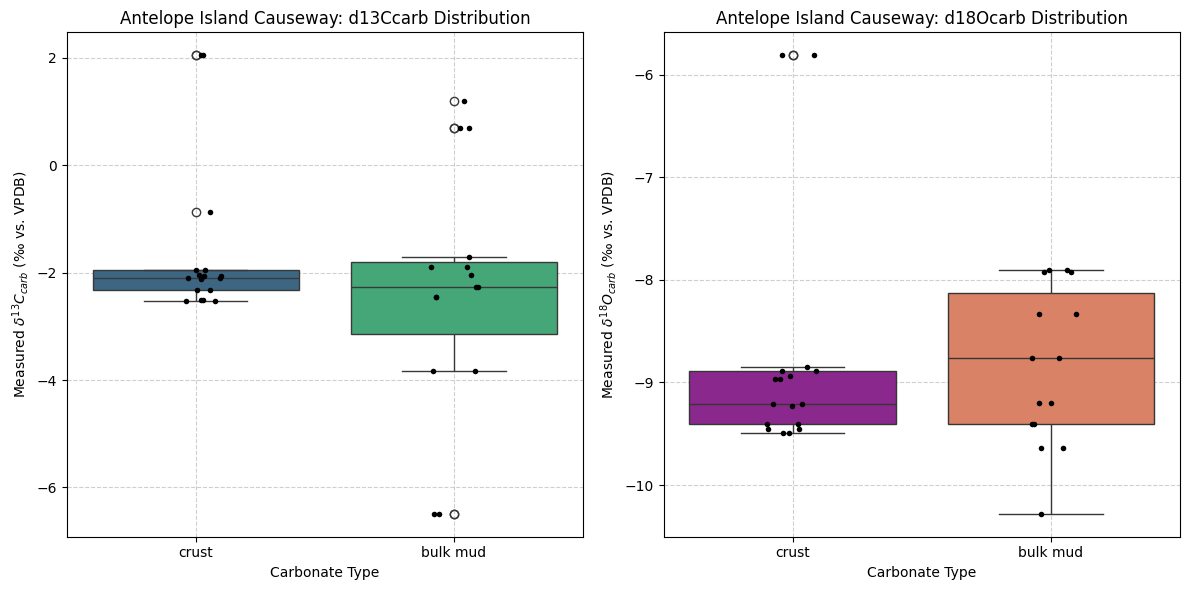

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Combine the two datasets for easier plotting
combined_data = pd.concat([crust_data, bulk_mud_data])

fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Box plot for d13C_carb
sns.boxplot(x='carb_type', y='d13C_carb', data=combined_data, ax=axs[0], palette='viridis')
sns.stripplot(x='carb_type', y='d13C_carb', data=combined_data, ax=axs[0], color='black', size=4, jitter=True)
axs[0].set_title('Antelope Island Causeway: d13Ccarb Distribution')
axs[0].set_xlabel('Carbonate Type')
axs[0].set_ylabel(r'Measured $\delta^{13}C_{carb}$ (‰ vs. VPDB)')
axs[0].grid(True, linestyle='--', alpha=0.6)

# Box plot for d18O_carb
sns.boxplot(x='carb_type', y='d18O_carb', data=combined_data, ax=axs[1], palette='plasma')
sns.stripplot(x='carb_type', y='d18O_carb', data=combined_data, ax=axs[1], color='black', size=4, jitter=True)
axs[1].set_title('Antelope Island Causeway: d18Ocarb Distribution')
axs[1].set_xlabel('Carbonate Type')
axs[1].set_ylabel(r'Measured $\delta^{18}O_{carb}$ (‰ vs. VPDB)')
axs[1].grid(True, linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()
fig.savefig('Antelope_Island_crust_vs_bulk_mud_distributions.pdf', bbox_inches='tight')



--- 3-sigma outlier check for d18O_carb in Antelope Island Combined Dataset (BEFORE exclusion)---
Mean d18O_carb: -8.81
Std Dev d18O_carb: 0.97
Upper 3-sigma bound for d18O_carb: -5.90
Highest d18O_carb value: -5.81
The highest d18O_carb value IS a 3-sigma outlier. Excluding it for this plot's Panel C.
-----------------------------------------------------------------------


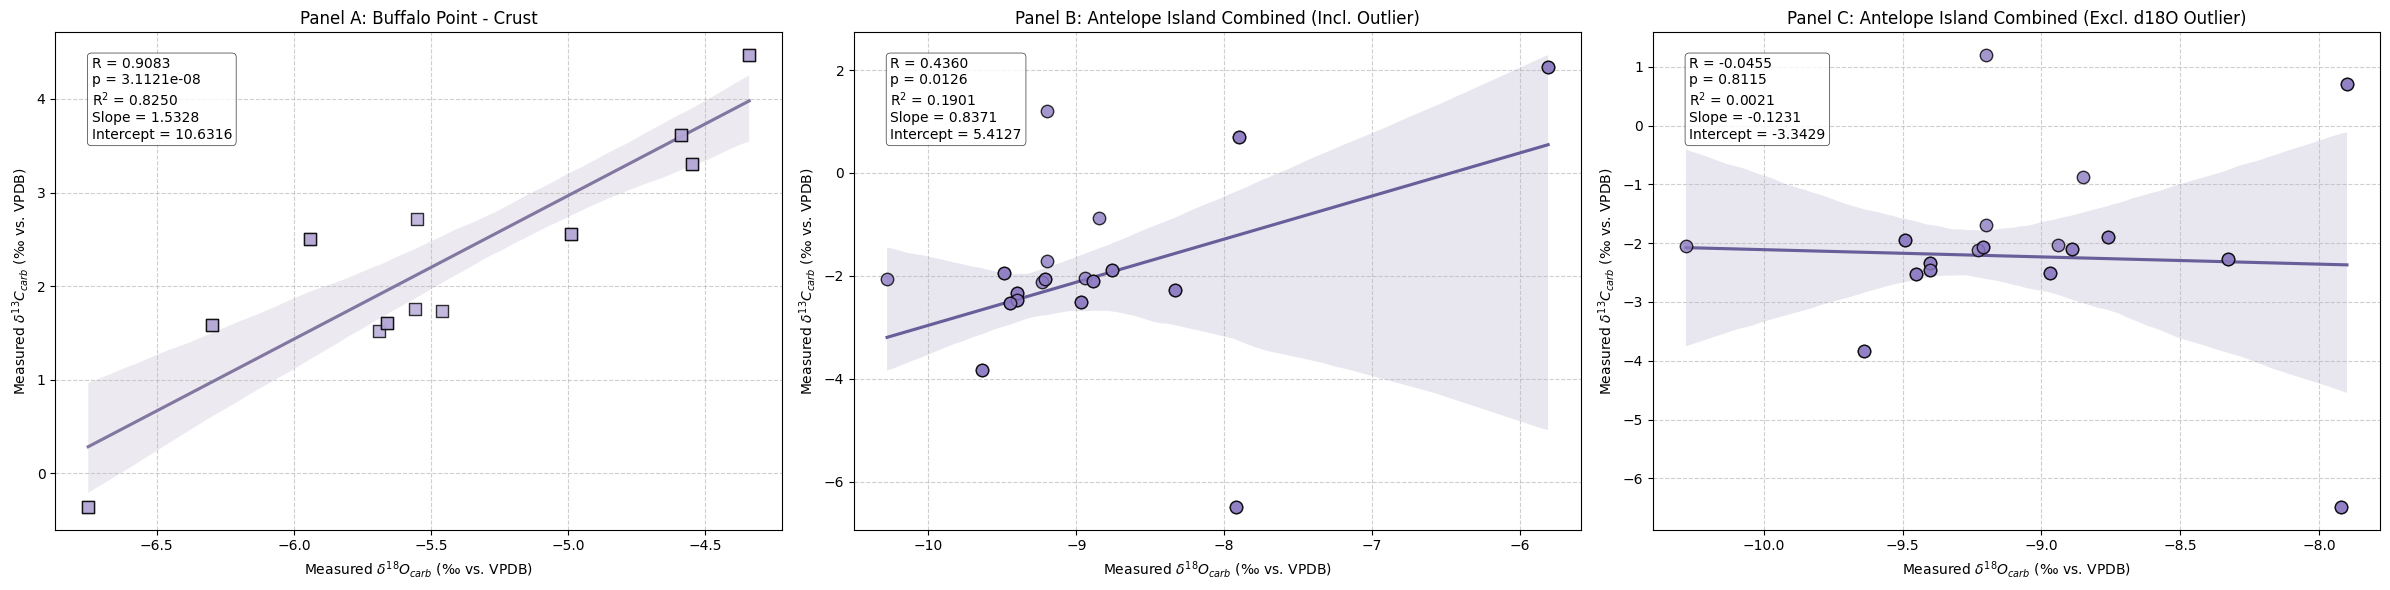

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import linregress
import pandas as pd # Import pandas to read the excel file
import numpy as np # Import numpy for nan

# Load merged_gsl_data to ensure it is defined (if not already)
# This is assumed to be available from previous cells, but we'll include it for robustness
if 'merged_gsl_data' not in locals():
    merged_gsl_data = pd.read_excel('gsl_d18O_model_with_saltair.xlsx')

# Filter data specifically for 'Buffalo Point - crust'
buffalo_crust_data = merged_gsl_data[
    (merged_gsl_data['Site'] == 'Buffalo Point') &
    (merged_gsl_data['carb_type'] == 'crust')
].dropna(subset=['d13C_carb', 'd18O_carb'])

# Prepare the base data frame for all filtering operations (no grain coating, no Ladyfinger Point)
filtered_data_base = merged_gsl_data.dropna(subset=['d13C_carb', 'd18O_carb']).copy()
filtered_data_base = filtered_data_base[
    (filtered_data_base['carb_type'] != 'grain coating') &
    (filtered_data_base['Site'] != 'Ladyfinger Point')
].copy()

# Create a working copy for filtered_data_for_analysis for d13C_carb outlier removal (if any)
filtered_data_for_analysis = filtered_data_base.copy()

# --- Outlier removal for Antelope Island Causeway - crust d13C_carb (3-sigma rule) ---
anti_crust_condition = (filtered_data_for_analysis['Site'] == 'Antelope Island Causeway') & \
                       (filtered_data_for_analysis['carb_type'] == 'crust')
anti_crust_data_for_d13c_outlier = filtered_data_for_analysis[anti_crust_condition].copy()

if not anti_crust_data_for_d13c_outlier.empty and anti_crust_data_for_d13c_outlier['d13C_carb'].nunique() > 1:
    mean_d13c_d13c = anti_crust_data_for_d13c_outlier['d13C_carb'].mean()
    std_d13c_d13c = anti_crust_data_for_d13c_outlier['d13C_carb'].std()
    lower_bound_d13c = mean_d13c_d13c - 3 * std_d13c_d13c
    upper_bound_d13c = mean_d13c_d13c + 3 * std_d13c_d13c
    outliers_d13c = anti_crust_data_for_d13c_outlier[(anti_crust_data_for_d13c_outlier['d13C_carb'] < lower_bound_d13c) | (anti_crust_data_for_d13c_outlier['d13C_carb'] > upper_bound_d13c)]
    if not outliers_d13c.empty:
        filtered_data_for_analysis = filtered_data_for_analysis.drop(outliers_d13c.index)

# --- Prepare the combined Antelope Island data for plotting ---

# 1. Antelope Island combined INCLUDING d18O_carb outlier
antelope_island_combined_df_original = filtered_data_for_analysis[
    (filtered_data_for_analysis['Site'] == 'Antelope Island Causeway') &
    (filtered_data_for_analysis['carb_type'].isin(['crust', 'bulk mud']))
].copy()

# 2. Antelope Island combined EXCLUDING d18O_carb outlier
antelope_island_combined_df_no_lowest = antelope_island_combined_df_original.copy()

print("\n--- 3-sigma outlier check for d18O_carb in Antelope Island Combined Dataset (BEFORE exclusion)---")
if not antelope_island_combined_df_original.empty and antelope_island_combined_df_original['d18O_carb'].nunique() > 1:
    mean_d18o = antelope_island_combined_df_original['d18O_carb'].mean()
    std_d18o = antelope_island_combined_df_original['d18O_carb'].std()
    upper_bound_d18o = mean_d18o + 3 * std_d18o
    max_d18o_carb = antelope_island_combined_df_original['d18O_carb'].max()

    print(f"Mean d18O_carb: {mean_d18o:.2f}")
    print(f"Std Dev d18O_carb: {std_d18o:.2f}")
    print(f"Upper 3-sigma bound for d18O_carb: {upper_bound_d18o:.2f}")
    print(f"Highest d18O_carb value: {max_d18o_carb:.2f}")

    if max_d18o_carb > upper_bound_d18o:
        print("The highest d18O_carb value IS a 3-sigma outlier. Excluding it for this plot's Panel C.")
        # Exclude the outlier from the DataFrame used for Panel C
        antelope_island_combined_df_no_lowest = antelope_island_combined_df_no_lowest[antelope_island_combined_df_no_lowest['d18O_carb'] != max_d18o_carb]
    else:
        print("The highest d18O_carb value IS NOT a 3-sigma outlier.")
else:
    print("Not enough data to perform 3-sigma outlier check for d18O_carb.")
print("-----------------------------------------------------------------------")


# Create a figure with three subplots side-by-side
fig, axs = plt.subplots(1, 3, figsize=(24, 6)) # Changed to 3 panels

# --- Panel A: Buffalo Point - Crust Regression ---
ax0 = axs[0]

# Plot the regression with 95% confidence interval for Buffalo Point - Crust
sns.regplot(x='d18O_carb', y='d13C_carb', data=buffalo_crust_data,
            ax=ax0, color='#b4a7d6', marker='s', ci=95,
            scatter_kws={'s': 80, 'edgecolor': 'k', 'zorder': 5},
            line_kws={'color': '#8277a0'})

# Perform linear regression to get parameters for Buffalo Point - Crust
if len(buffalo_crust_data) > 1 and buffalo_crust_data['d13C_carb'].nunique() > 1 and buffalo_crust_data['d18O_carb'].nunique() > 1:
    slope_bp, intercept_bp, r_value_bp, p_value_bp, std_err_bp = linregress(buffalo_crust_data['d18O_carb'], buffalo_crust_data['d13C_carb'])
    r_squared_bp = r_value_bp**2

    # Add regression statistics to the plot
    stats_text_bp = f'R = {r_value_bp:.4f}\np = {p_value_bp:.4e}\nR$^2$ = {r_squared_bp:.4f}\nSlope = {slope_bp:.4f}\nIntercept = {intercept_bp:.4f}'
    ax0.text(0.05, 0.95, stats_text_bp, transform=ax0.transAxes, ha='left', va='top', fontsize=10, bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="black", lw=0.5, alpha=0.8))

ax0.set_xlabel(r'Measured $\delta^{18}O_{carb}$ (‰ vs. VPDB)')
ax0.set_ylabel(r'Measured $\delta^{13}C_{carb}$ (‰ vs. VPDB)')
ax0.set_title(r'Panel A: Buffalo Point - Crust')
ax0.grid(True, linestyle='--', alpha=0.6)

# --- Panel B: Antelope Island Combined Muds and Crusts Regression (INCLUDING d18O_carb outlier) ---
ax1 = axs[1]

# Perform linear regression to get parameters for Antelope Island combined (INCLUDING outlier)
slope_ai_original, intercept_ai_original, r_value_ai_original, p_value_ai_original, std_err_ai_original = np.nan, np.nan, np.nan, np.nan, np.nan
r_squared_ai_original = np.nan

if not antelope_island_combined_df_original.empty and antelope_island_combined_df_original['d13C_carb'].nunique() > 1 and antelope_island_combined_df_original['d18O_carb'].nunique() > 1:
    slope_ai_original, intercept_ai_original, r_value_ai_original, p_value_ai_original, std_err_ai_original = linregress(antelope_island_combined_df_original['d18O_carb'], antelope_island_combined_df_original['d13C_carb'])
    r_squared_ai_original = r_value_ai_original**2

# Plot the regression with 95% confidence interval for Antelope Island Combined (INCLUDING outlier)
sns.regplot(x='d18O_carb', y='d13C_carb', data=antelope_island_combined_df_original,
            ax=ax1, color='#8e7cc3', marker='o', ci=95,
            scatter_kws={'s': 80, 'edgecolor': 'k', 'zorder': 5},
            line_kws={'color': '#6a5e9a'})

# Add regression statistics to the plot
if not np.isnan(r_value_ai_original):
    stats_text_ai_original = f'R = {r_value_ai_original:.4f}\np = {p_value_ai_original:.4f}\nR$^2$ = {r_squared_ai_original:.4f}\nSlope = {slope_ai_original:.4f}\nIntercept = {intercept_ai_original:.4f}'
    ax1.text(0.05, 0.95, stats_text_ai_original, transform=ax1.transAxes, ha='left', va='top', fontsize=10, bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="black", lw=0.5, alpha=0.8))

ax1.set_xlabel(r'Measured $\delta^{18}O_{carb}$ (‰ vs. VPDB)')
ax1.set_ylabel(r'Measured $\delta^{13}C_{carb}$ (‰ vs. VPDB)')
ax1.set_title(r'Panel B: Antelope Island Combined (Incl. Outlier)')
ax1.grid(True, linestyle='--', alpha=0.6)

# --- Panel C: Antelope Island Combined Muds and Crusts Regression (EXCLUDING d18O_carb outlier) ---
ax2 = axs[2] # New subplot for Panel C

# Perform linear regression to get parameters for Antelope Island combined (EXCLUDING outlier)
slope_ai_no_lowest, intercept_ai_no_lowest, r_value_ai_no_lowest, p_value_ai_no_lowest, std_err_ai_no_lowest = np.nan, np.nan, np.nan, np.nan, np.nan
r_squared_ai_no_lowest = np.nan

if not antelope_island_combined_df_no_lowest.empty and antelope_island_combined_df_no_lowest['d13C_carb'].nunique() > 1 and antelope_island_combined_df_no_lowest['d18O_carb'].nunique() > 1:
    slope_ai_no_lowest, intercept_ai_no_lowest, r_value_ai_no_lowest, p_value_ai_no_lowest, std_err_ai_no_lowest = linregress(antelope_island_combined_df_no_lowest['d18O_carb'], antelope_island_combined_df_no_lowest['d13C_carb'])
    r_squared_ai_no_lowest = r_value_ai_no_lowest**2

# Plot the regression with 95% confidence interval for Antelope Island Combined (EXCLUDING outlier)
sns.regplot(x='d18O_carb', y='d13C_carb', data=antelope_island_combined_df_no_lowest,
            ax=ax2, color='#8e7cc3', marker='o', ci=95,
            scatter_kws={'s': 80, 'edgecolor': 'k', 'zorder': 5},
            line_kws={'color': '#6a5e9a'})

# Add regression statistics to the plot
if not np.isnan(r_value_ai_no_lowest):
    stats_text_ai_no_lowest = f'R = {r_value_ai_no_lowest:.4f}\np = {p_value_ai_no_lowest:.4f}\nR$^2$ = {r_squared_ai_no_lowest:.4f}\nSlope = {slope_ai_no_lowest:.4f}\nIntercept = {intercept_ai_no_lowest:.4f}'
    ax2.text(0.05, 0.95, stats_text_ai_no_lowest, transform=ax2.transAxes, ha='left', va='top', fontsize=10, bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="black", lw=0.5, alpha=0.8))

ax2.set_xlabel(r'Measured $\delta^{18}O_{carb}$ (‰ vs. VPDB)')
ax2.set_ylabel(r'Measured $\delta^{13}C_{carb}$ (‰ vs. VPDB)')
ax2.set_title(r'Panel C: Antelope Island Combined (Excl. d18O Outlier)')
ax2.grid(True, linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()

fig.savefig('buffalo_antelope_combined_regression_comparison.pdf', bbox_inches='tight') # New filename

In [ ]:
from scipy import stats
import pandas as pd
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import os

# Mount Google Drive if not already mounted (to ensure file access)
from google.colab import drive
drive.mount('/content/drive')

# Set working directory (to ensure file access)
os.chdir('/content/drive/My Drive/GSL_d18O_model')

# Ensure merged_gsl_data is defined by providing the full path
merged_gsl_data = pd.read_excel("gsl_d18O_model_with_saltair.xlsx")

# Filter data for Antelope Island Causeway - crust
crust_data = merged_gsl_data[
    (merged_gsl_data['Site'] == 'Antelope Island Causeway') &
    (merged_gsl_data['carb_type'] == 'crust')
].dropna(subset=['d13C_carb', 'd18O_carb'])

# Filter data for Antelope Island Causeway - bulk mud
bulk_mud_data = merged_gsl_data[
    (merged_gsl_data['Site'] == 'Antelope Island Causeway') &
    (merged_gsl_data['carb_type'] == 'bulk mud')
].dropna(subset=['d13C_carb', 'd18O_carb'])

print("\n--- Statistical Comparison (Antelope Island Causeway - Crust vs. Bulk Mud) ---\n")

# --- d13C_carb Comparison ---
print("d13C_carb:")
if not crust_data.empty and not bulk_mud_data.empty:
    # Check for equal variances (Levene's test)
    levene_d13c = stats.levene(crust_data['d13C_carb'], bulk_mud_data['d13C_carb'])
    print(f"  Levene's test for d13C_carb (p-value): {levene_d13c.pvalue:.4f}")

    # Perform independent t-test (assume unequal variances if Levene's p < 0.05)
    if levene_d13c.pvalue < 0.05:
        t_stat_d13c, p_val_d13c = stats.ttest_ind(crust_data['d13C_carb'], bulk_mud_data['d13C_carb'], equal_var=False) # Welch's t-test
        print("  Performing Welch's t-test (unequal variances assumed)")
    else:
        t_stat_d13c, p_val_d13c = stats.ttest_ind(crust_data['d13C_carb'], bulk_mud_data['d13C_carb'], equal_var=True)
        print("  Performing Student's t-test (equal variances assumed)")

    print(f"  Mean d13C_carb (Crust): {crust_data['d13C_carb'].mean():.2f}")
    print(f"  Mean d13C_carb (Bulk Mud): {bulk_mud_data['d13C_carb'].mean():.2f}")
    print(f"  T-statistic (d13C_carb): {t_stat_d13c:.3f}, P-value: {p_val_d13c:.4f}")

    # Combine data for ANOVA and Tukey HSD
    combined_d13c_data = pd.concat([
        crust_data.assign(carb_type='crust')[['d13C_carb', 'carb_type']],
        bulk_mud_data.assign(carb_type='bulk mud')[['d13C_carb', 'carb_type']]
    ])

    # Perform One-Way ANOVA
    if len(combined_d13c_data['carb_type'].unique()) > 1:
        model_d13c = ols('d13C_carb ~ C(carb_type)', data=combined_d13c_data).fit()
        f_stat_d13c = model_d13c.fvalue
        p_value_anova_d13c = model_d13c.f_pvalue
        print(f"\n  One-Way ANOVA for d13C_carb: F-statistic={f_stat_d13c:.3f}, P-value={p_value_anova_d13c:.4f}")

        # Perform Tukey's HSD post-hoc test
        tukey_d13c = pairwise_tukeyhsd(endog=combined_d13c_data['d13C_carb'], groups=combined_d13c_data['carb_type'], alpha=0.05)
        print("  Tukey's HSD Post-Hoc Test for d13C_carb:")
        print(tukey_d13c)
    else:
        print("  Not enough unique carb_types for ANOVA/Tukey HSD for d13C_carb.")

else:
    print("  Not enough data to compare d13C_carb.")

print("\n--- d18O_carb Comparison ---")
# --- d18O_carb Comparison ---
if not crust_data.empty and not bulk_mud_data.empty:
    # Check for equal variances (Levene's test)
    levene_d18o = stats.levene(crust_data['d18O_carb'], bulk_mud_data['d18O_carb'])
    print(f"  Levene's test for d18O_carb (p-value): {levene_d18o.pvalue:.4f}")

    # Perform independent t-test (assume unequal variances if Levene's p < 0.05)
    if levene_d18o.pvalue < 0.05:
        t_stat_d18o, p_val_d18o = stats.ttest_ind(crust_data['d18O_carb'], bulk_mud_data['d18O_carb'], equal_var=False) # Welch's t-test
        print("  Performing Welch's t-test (unequal variances assumed)")
    else:
        t_stat_d18o, p_val_d18o = stats.ttest_ind(crust_data['d18O_carb'], bulk_mud_data['d18O_carb'], equal_var=True)
        print("  Performing Student's t-test (equal variances assumed)")

    print(f"  Mean d18O_carb (Crust): {crust_data['d18O_carb'].mean():.2f}")
    print(f"  Mean d18O_carb (Bulk Mud): {bulk_mud_data['d18O_carb'].mean():.2f}")
    print(f"  T-statistic (d18O_carb): {t_stat_d18o:.3f}, P-value: {p_val_d18o:.4f}")

    # Combine data for ANOVA and Tukey HSD
    combined_d18o_data = pd.concat([
        crust_data.assign(carb_type='crust')[['d18O_carb', 'carb_type']],
        bulk_mud_data.assign(carb_type='bulk mud')[['d18O_carb', 'carb_type']]
    ])

    # Perform One-Way ANOVA
    if len(combined_d18o_data['carb_type'].unique()) > 1:
        model_d18o = ols('d18O_carb ~ C(carb_type)', data=combined_d18o_data).fit()
        f_stat_d18o = model_d18o.fvalue
        p_value_anova_d18o = model_d18o.f_pvalue
        print(f"\n  One-Way ANOVA for d18O_carb: F-statistic={f_stat_d18o:.3f}, P-value={p_value_anova_d18o:.4f}")

        # Perform Tukey's HSD post-hoc test
        tukey_d18o = pairwise_tukeyhsd(endog=combined_d18o_data['d18O_carb'], groups=combined_d18o_data['carb_type'], alpha=0.05)
        print("  Tukey's HSD Post-Hoc Test for d18O_carb:")
        print(tukey_d18o)
    else:
        print("  Not enough unique carb_types for ANOVA/Tukey HSD for d18O_carb.")

else:
    print("  Not enough data to compare d18O_carb.")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).

--- Statistical Comparison (Antelope Island Causeway - Crust vs. Bulk Mud) ---

d13C_carb:
  Levene's test for d13C_carb (p-value): 0.1261
  Performing Student's t-test (equal variances assumed)
  Mean d13C_carb (Crust): -1.64
  Mean d13C_carb (Bulk Mud): -2.34
  T-statistic (d13C_carb): 1.056, P-value: 0.2995

  One-Way ANOVA for d13C_carb: F-statistic=1.115, P-value=0.2995
  Tukey's HSD Post-Hoc Test for d13C_carb:
 Multiple Comparison of Means - Tukey HSD, FWER=0.05 
 group1  group2 meandiff p-adj   lower  upper  reject
-----------------------------------------------------
bulk mud  crust   0.6965 0.2995 -0.6507 2.0437  False
-----------------------------------------------------

--- d18O_carb Comparison ---
  Levene's test for d18O_carb (p-value): 0.8404
  Performing Student's t-test (equal variances assumed)
  Mean d18O_carb (Crust): -8.79
  Mean d18O_c

In [ ]:
import pandas as pd
import os
import numpy as np

# Mount Google Drive if not already mounted
from google.colab import drive
drive.mount('/content/drive')

# Set working directory
os.chdir('/content/drive/My Drive/GSL_d18O_model')

# Load the new CSV file
new_data = pd.read_csv("CoreTop2-DICLWplot.csv")

# Helper function to remove 3-sigma outliers from a DataFrame column
def remove_3sigma_outliers(df, column_name):
    if df.empty or df[column_name].nunique() < 2:
        # Not enough data to calculate meaningful std dev or no variance
        return df

    mean_val = df[column_name].mean()
    std_val = df[column_name].std()

    if std_val == 0: # Avoid division by zero or infinite bounds if all values are the same
        return df

    lower_bound = mean_val - 3 * std_val
    upper_bound = mean_val + 3 * std_val

    # Filter out outliers
    filtered_df = df[(df[column_name] >= lower_bound) & (df[column_name] <= upper_bound)]

    return filtered_df

# Filter data for Antelope Island Causeway bulk muds
antelope_muds = new_data[
    (new_data['Site'] == 'Antelope Island Causeway') &
    (new_data['carb_type'] == 'bulk mud')
].dropna(subset=['d13C_carb', 'd18O_carb'])

# Filter data for Antelope Island Causeway crusts
antelope_crusts = new_data[
    (new_data['Site'] == 'Antelope Island Causeway') &
    (new_data['carb_type'] == 'crust')
].dropna(subset=['d13C_carb', 'd18O_carb'])

# --- Process Muds data ---
muds_d13C_cleaned = remove_3sigma_outliers(antelope_muds.copy(), 'd13C_carb')
muds_d18O_cleaned = remove_3sigma_outliers(antelope_muds.copy(), 'd18O_carb')

# Calculate variance for cleaned muds
variance_d13C_muds_cleaned = muds_d13C_cleaned['d13C_carb'].var()
variance_d18O_muds_cleaned = muds_d18O_cleaned['d18O_carb'].var()

print(f"--- Variances for Antelope Island Causeway Bulk Muds (3-sigma outliers removed) ---")
print(f"Variance in d13Ccarb: {variance_d13C_muds_cleaned:.4f}")
print(f"Variance in d18Ocarb: {variance_d18O_muds_cleaned:.4f}")

# --- Process Crusts data ---
crusts_d13C_cleaned = remove_3sigma_outliers(antelope_crusts.copy(), 'd13C_carb')
crusts_d18O_cleaned = remove_3sigma_outliers(antelope_crusts.copy(), 'd18O_carb')

# Calculate variance for cleaned crusts
variance_d13C_crusts_cleaned = crusts_d13C_cleaned['d13C_carb'].var()
variance_d18O_crusts_cleaned = crusts_d18O_cleaned['d18O_carb'].var()

print(f"\n--- Variances for Antelope Island Causeway Crusts (3-sigma outliers removed) ---")
print(f"Variance in d13Ccarb: {variance_d13C_crusts_cleaned:.4f}")
print(f"Variance in d18Ocarb: {variance_d18O_crusts_cleaned:.4f}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
--- Variances for Antelope Island Causeway Bulk Muds (3-sigma outliers removed) ---
Variance in d13Ccarb: 5.1698
Variance in d18Ocarb: 0.6445

--- Variances for Antelope Island Causeway Crusts (3-sigma outliers removed) ---
Variance in d13Ccarb: 1.8980
Variance in d18Ocarb: 1.1783


In [ ]:
from scipy import stats
import pandas as pd
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import os

# Mount Google Drive if not already mounted
from google.colab import drive
drive.mount('/content/drive')

# Set working directory
os.chdir('/content/drive/My Drive/GSL_d18O_model')

# Ensure merged_gsl_data is defined
merged_gsl_data = pd.read_excel("gsl_d18O_model_with_saltair.xlsx")

# Filter data for Buffalo Point - white intraclast
white_intraclast_data = merged_gsl_data[
    (merged_gsl_data['Site'] == 'Buffalo Point') &
    (merged_gsl_data['carb_type'] == 'white intraclast')
].dropna(subset=['d13C_carb', 'd18O_carb'])

# Filter data for Buffalo Point - bulk microbial boundstone
bulk_microbial_boundstone_data = merged_gsl_data[
    (merged_gsl_data['Site'] == 'Buffalo Point') &
    (merged_gsl_data['carb_type'] == 'bulk microbial boundstone')
].dropna(subset=['d13C_carb', 'd18O_carb'])

print("\n--- Statistical Comparison (Buffalo Point - White Intraclast vs. Bulk Microbial Boundstone) ---\n")

# --- d13C_carb Comparison ---
print("d13C_carb:")
if not white_intraclast_data.empty and not bulk_microbial_boundstone_data.empty:
    # Check for equal variances (Levene's test)
    levene_d13c = stats.levene(white_intraclast_data['d13C_carb'], bulk_microbial_boundstone_data['d13C_carb'])
    print(f"  Levene's test for d13C_carb (p-value): {levene_d13c.pvalue:.4f}")

    # Perform independent t-test (assume unequal variances if Levene's p < 0.05)
    if levene_d13c.pvalue < 0.05:
        t_stat_d13c, p_val_d13c = stats.ttest_ind(white_intraclast_data['d13C_carb'], bulk_microbial_boundstone_data['d13C_carb'], equal_var=False) # Welch's t-test
        print("  Performing Welch's t-test (unequal variances assumed)")
    else:
        t_stat_d13c, p_val_d13c = stats.ttest_ind(white_intraclast_data['d13C_carb'], bulk_microbial_boundstone_data['d13C_carb'], equal_var=True)
        print("  Performing Student's t-test (equal variances assumed)")

    print(f"  Mean d13C_carb (White Intraclast): {white_intraclast_data['d13C_carb'].mean():.2f}")
    print(f"  Mean d13C_carb (Bulk Microbial Boundstone): {bulk_microbial_boundstone_data['d13C_carb'].mean():.2f}")
    print(f"  T-statistic (d13C_carb): {t_stat_d13c:.3f}, P-value: {p_val_d13c:.4f}")

    # Combine data for ANOVA and Tukey HSD
    combined_d13c_data = pd.concat([
        white_intraclast_data.assign(carb_type='white intraclast')[['d13C_carb', 'carb_type']],
        bulk_microbial_boundstone_data.assign(carb_type='bulk microbial boundstone')[['d13C_carb', 'carb_type']]
    ])

    # Perform One-Way ANOVA
    if len(combined_d13c_data['carb_type'].unique()) > 1:
        model_d13c = ols('d13C_carb ~ C(carb_type)', data=combined_d13c_data).fit()
        f_stat_d13c = model_d13c.fvalue
        p_value_anova_d13c = model_d13c.f_pvalue
        print(f"\n  One-Way ANOVA for d13C_carb: F-statistic={f_stat_d13c:.3f}, P-value={p_value_anova_d13c:.4f}")

        # Perform Tukey's HSD post-hoc test
        tukey_d13c = pairwise_tukeyhsd(endog=combined_d13c_data['d13C_carb'], groups=combined_d13c_data['carb_type'], alpha=0.05)
        print("  Tukey's HSD Post-Hoc Test for d13C_carb:")
        print(tukey_d13c)
    else:
        print("  Not enough unique carb_types for ANOVA/Tukey HSD for d13C_carb.")

else:
    print("  Not enough data to compare d13C_carb.")

print("\n--- d18O_carb Comparison ---")
# --- d18O_carb Comparison ---
if not white_intraclast_data.empty and not bulk_microbial_boundstone_data.empty:
    # Check for equal variances (Levene's test)
    levene_d18o = stats.levene(white_intraclast_data['d18O_carb'], bulk_microbial_boundstone_data['d18O_carb'])
    print(f"  Levene's test for d18O_carb (p-value): {levene_d18o.pvalue:.4f}")

    # Perform independent t-test (assume unequal variances if Levene's p < 0.05)
    if levene_d18o.pvalue < 0.05:
        t_stat_d18o, p_val_d18o = stats.ttest_ind(white_intraclast_data['d18O_carb'], bulk_microbial_boundstone_data['d18O_carb'], equal_var=False) # Welch's t-test
        print("  Performing Welch's t-test (unequal variances assumed)")
    else:
        t_stat_d18o, p_val_d18o = stats.ttest_ind(white_intraclast_data['d18O_carb'], bulk_microbial_boundstone_data['d18O_carb'], equal_var=True)
        print("  Performing Student's t-test (equal variances assumed)")

    print(f"  Mean d18O_carb (White Intraclast): {white_intraclast_data['d18O_carb'].mean():.2f}")
    print(f"  Mean d18O_carb (Bulk Microbial Boundstone): {bulk_microbial_boundstone_data['d18O_carb'].mean():.2f}")
    print(f"  T-statistic (d18O_carb): {t_stat_d18o:.3f}, P-value: {p_val_d18o:.4f}")

    # Combine data for ANOVA and Tukey HSD
    combined_d18o_data = pd.concat([
        white_intraclast_data.assign(carb_type='white intraclast')[['d18O_carb', 'carb_type']],
        bulk_microbial_boundstone_data.assign(carb_type='bulk microbial boundstone')[['d18O_carb', 'carb_type']]
    ])

    # Perform One-Way ANOVA
    if len(combined_d18o_data['carb_type'].unique()) > 1:
        model_d18o = ols('d18O_carb ~ C(carb_type)', data=combined_d18o_data).fit()
        f_stat_d18o = model_d18o.fvalue
        p_value_anova_d18o = model_d18o.f_pvalue
        print(f"\n  One-Way ANOVA for d18O_carb: F-statistic={f_stat_d18o:.3f}, P-value={p_value_anova_d18o:.4f}")

        # Perform Tukey's HSD post-hoc test
        tukey_d18o = pairwise_tukeyhsd(endog=combined_d18o_data['d18O_carb'], groups=combined_d18o_data['carb_type'], alpha=0.05)
        print("  Tukey's HSD Post-Hoc Test for d18O_carb:")
        print(tukey_d18o)
    else:
        print("  Not enough unique carb_types for ANOVA/Tukey HSD for d18O_carb.")

else:
    print("  Not enough data to compare d18O_carb.")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).

--- Statistical Comparison (Buffalo Point - White Intraclast vs. Bulk Microbial Boundstone) ---

d13C_carb:
  Levene's test for d13C_carb (p-value): 0.4005
  Performing Student's t-test (equal variances assumed)
  Mean d13C_carb (White Intraclast): 4.45
  Mean d13C_carb (Bulk Microbial Boundstone): 3.89
  T-statistic (d13C_carb): 3.618, P-value: 0.0006

  One-Way ANOVA for d13C_carb: F-statistic=13.092, P-value=0.0006
  Tukey's HSD Post-Hoc Test for d13C_carb:
              Multiple Comparison of Means - Tukey HSD, FWER=0.05              
          group1               group2      meandiff p-adj  lower  upper  reject
-------------------------------------------------------------------------------
bulk microbial boundstone white intraclast   0.5599 0.0006 0.2502 0.8697   True
-------------------------------------------------------------------------------

--- 

<>:41: SyntaxWarning: invalid escape sequence '\d'
<>:59: SyntaxWarning: invalid escape sequence '\d'
<>:41: SyntaxWarning: invalid escape sequence '\d'
<>:59: SyntaxWarning: invalid escape sequence '\d'
/tmp/ipython-input-1058475246.py:41: SyntaxWarning: invalid escape sequence '\d'
  ax0.set_title('Buffalo Point Crust: Modeled $\delta^{18}O_{c}$ vs. Measured $\delta^{18}O_{carb}$ ') # Updated title
/tmp/ipython-input-1058475246.py:59: SyntaxWarning: invalid escape sequence '\d'
  ax1.set_title('Antelope Island Crust: Modeled $\delta^{18}O_{c}$ vs. Measured $\delta^{18}O_{carb}$ ') # Updated title


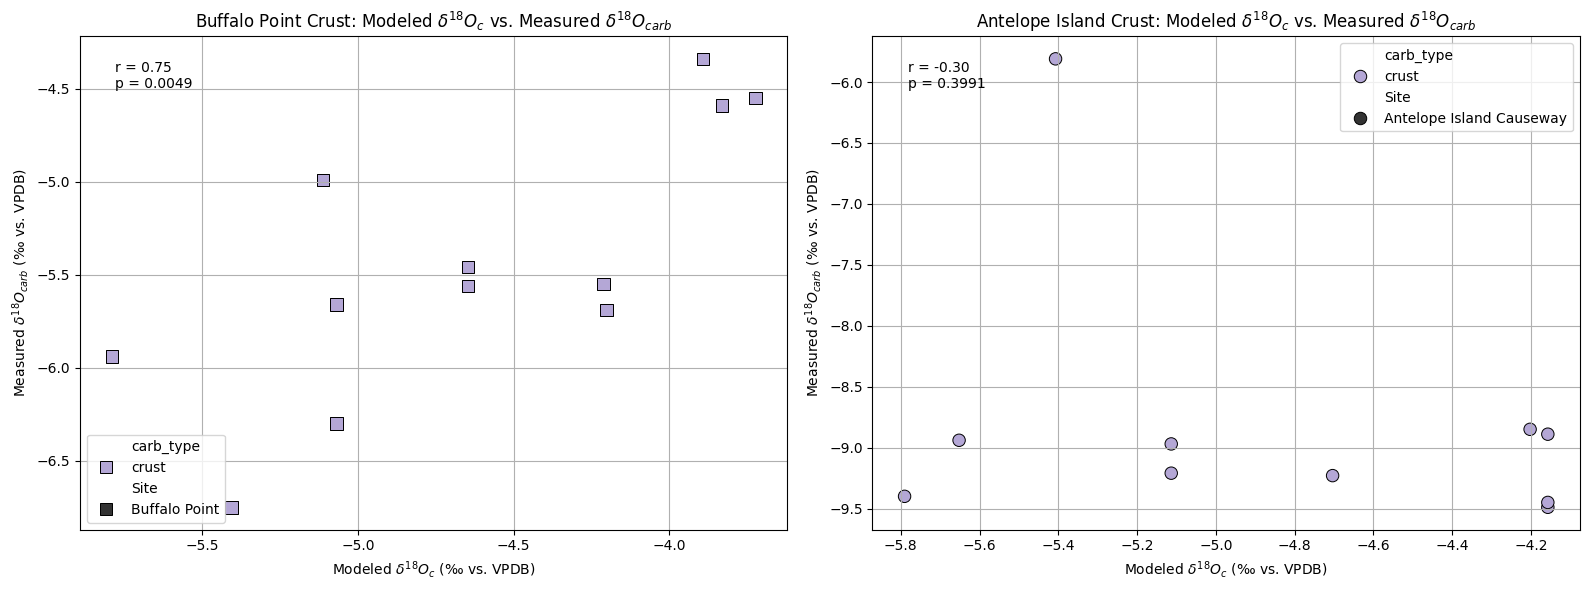

In [ ]:
from scipy.stats import linregress, pearsonr
import string
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

# Re-load merged_gsl_data if necessary (to ensure it's up-to-date and accessible)
if 'merged_gsl_data' not in locals():
    merged_gsl_data = pd.read_excel('gsl_d18O_model_with_saltair.xlsx')

# Filter data for Buffalo Point crust
buffalo_crust_d18o = merged_gsl_data[
    (merged_gsl_data['Site'] == 'Buffalo Point') &
    (merged_gsl_data['carb_type'] == 'crust')
].dropna(subset=['d18O_c_303K', 'd18O_carb']) # Changed 'Elev_m' to 'd18O_c_303K'

# Filter data for Antelope Island Causeway crust
antelope_crust_d18o = merged_gsl_data[
    (merged_gsl_data['Site'] == 'Antelope Island Causeway') &
    (merged_gsl_data['carb_type'] == 'crust')
].dropna(subset=['d18O_c_303K', 'd18O_carb']) # Changed 'Elev_m' to 'd18O_c_303K'

# Create a figure with two subplots side-by-side
fig, axs = plt.subplots(1, 2, figsize=(16, 6))

# Define markers for each site (assuming these are defined in the broader context, redefining for safety)
site_markers = {'Ladyfinger Point': 'D', 'Buffalo Point': 's', 'Antelope Island Causeway': 'o'}
# Define colors for each carb_type (assuming these are defined in the broader context, redefining for safety)
carb_colors = {'bulk microbial boundstone': '#93c47d', 'crust': '#b4a7d6', 'white intraclast': '#ece9c9', 'bulk mud': '#351c75', 'grain coating': '#a64d79'}

## Panel 1: Buffalo Point Crusts (Modeled d18Oc vs d18Ocarb)
ax0 = axs[0]

sns.scatterplot(x='d18O_c_303K', y='d18O_carb', data=buffalo_crust_d18o,
                hue='carb_type', palette=carb_colors, style='Site', markers=site_markers,
                s=80, edgecolor='k', ax=ax0, legend='full')

ax0.set_xlabel(r'Modeled $\delta^{18}O_{c}$ (‰ vs. VPDB)') # Updated xlabel
ax0.set_ylabel(r'Measured $\delta^{18}O_{carb}$ (‰ vs. VPDB)')
ax0.set_title('Buffalo Point Crust: Modeled $\delta^{18}O_{c}$ vs. Measured $\delta^{18}O_{carb}$ ') # Updated title
ax0.grid(True)

if not buffalo_crust_d18o.empty and buffalo_crust_d18o['d18O_c_303K'].nunique() > 1 and buffalo_crust_d18o['d18O_carb'].nunique() > 1:
    corr, p_value = pearsonr(buffalo_crust_d18o['d18O_c_303K'], buffalo_crust_d18o['d18O_carb']) # Updated x-variable
    ax0.text(0.05, 0.95, f'r = {corr:.2f}\np = {p_value:.4f}', transform=ax0.transAxes, ha='left', va='top')
elif not buffalo_crust_d18o.empty:
    ax0.text(0.05, 0.95, 'Correlation not defined\n(constant input)', transform=ax0.transAxes, ha='left', va='top')

## Panel 2: Antelope Island Causeway Crusts (Modeled d18Oc vs d18Ocarb)
ax1 = axs[1]

sns.scatterplot(x='d18O_c_303K', y='d18O_carb', data=antelope_crust_d18o,
                hue='carb_type', palette=carb_colors, style='Site', markers=site_markers,
                s=80, edgecolor='k', ax=ax1, legend='full')

ax1.set_xlabel(r'Modeled $\delta^{18}O_{c}$ (‰ vs. VPDB)') # Updated xlabel
ax1.set_ylabel(r'Measured $\delta^{18}O_{carb}$ (‰ vs. VPDB)')
ax1.set_title('Antelope Island Crust: Modeled $\delta^{18}O_{c}$ vs. Measured $\delta^{18}O_{carb}$ ') # Updated title
ax1.grid(True)

if not antelope_crust_d18o.empty and antelope_crust_d18o['d18O_c_303K'].nunique() > 1 and antelope_crust_d18o['d18O_carb'].nunique() > 1:
    corr, p_value = pearsonr(antelope_crust_d18o['d18O_c_303K'], antelope_crust_d18o['d18O_carb']) # Updated x-variable
    ax1.text(0.05, 0.95, f'r = {corr:.2f}\np = {p_value:.4f}', transform=ax1.transAxes, ha='left', va='top')
elif not antelope_crust_d18o.empty:
    ax1.text(0.05, 0.95, 'Correlation not defined\n(constant input)', transform=ax1.transAxes, ha='left', va='top')

plt.tight_layout()
plt.show()
fig.savefig('modeled_d18Oc_vs_d18o_carb_crusts.pdf', bbox_inches='tight') # Updated filename

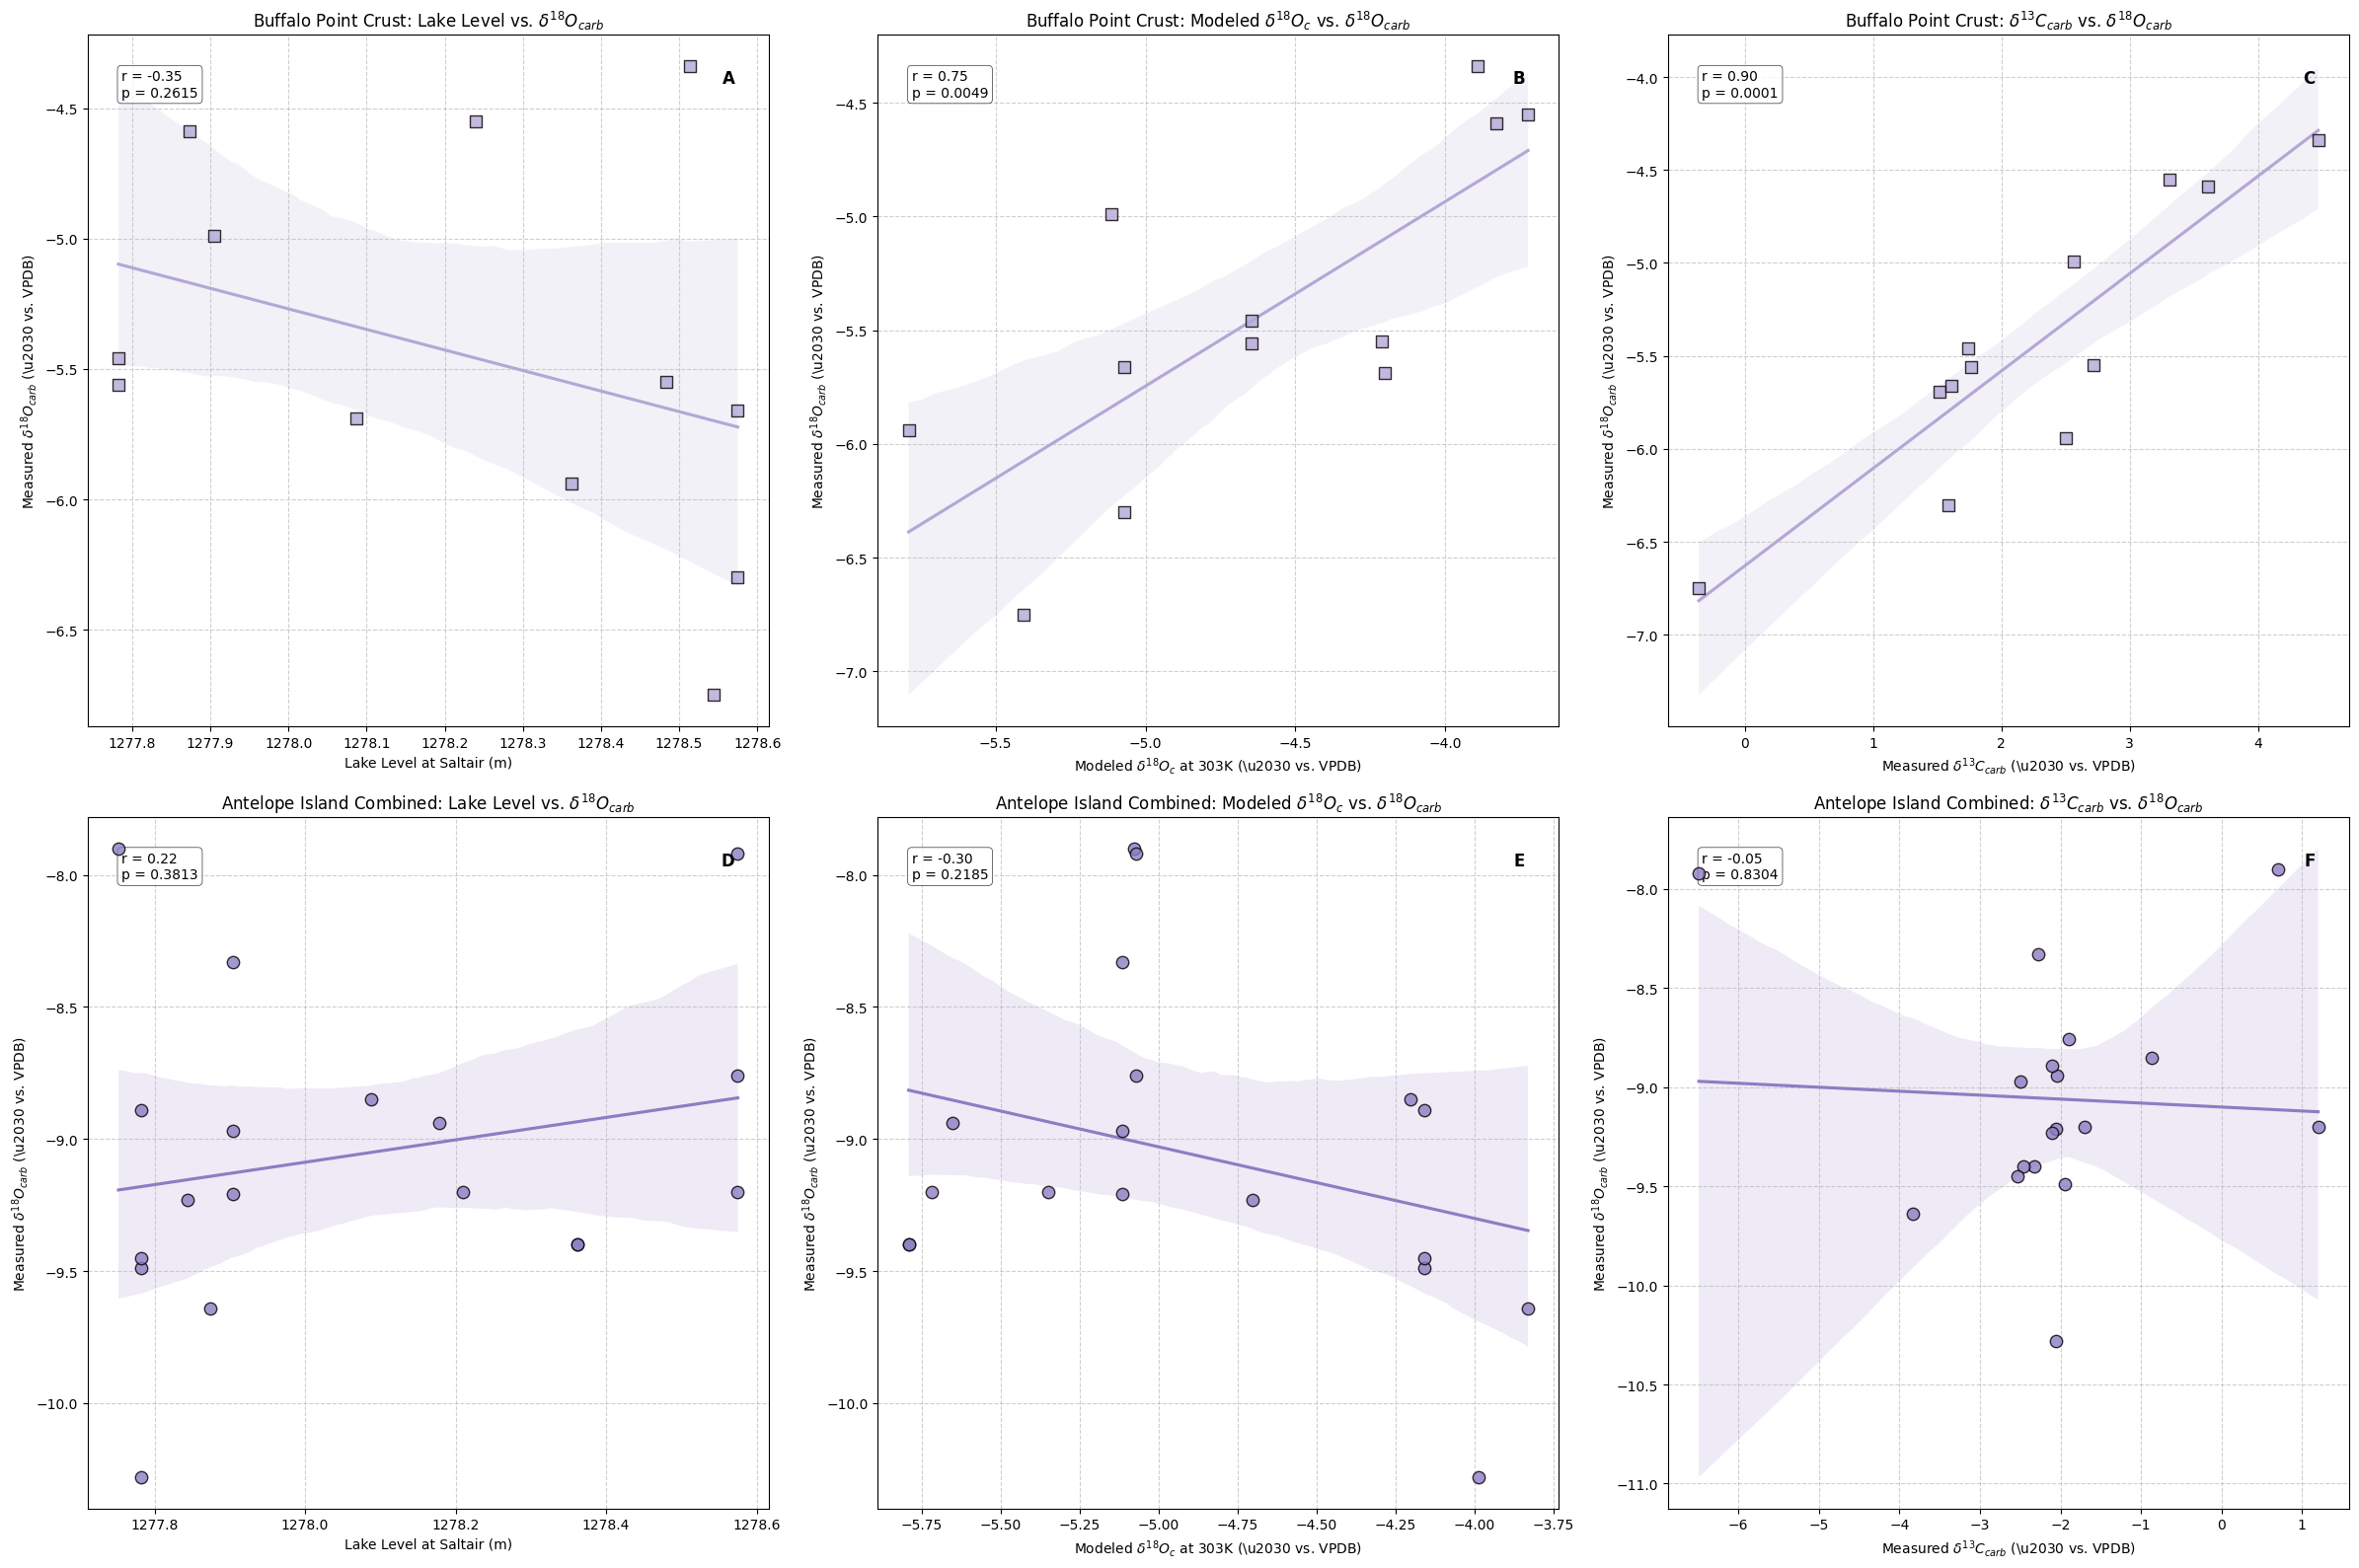

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr
import numpy as np
import string

# Define markers and colors for consistent plotting (re-declared for clarity in this step)
site_markers = {'Ladyfinger Point': 'D', 'Buffalo Point': 's', 'Antelope Island Causeway': 'o'}
carb_colors = {
    'bulk microbial boundstone': '#93c47d',
    'crust': '#b4a7d6',
    'white intraclast': '#ece9c9',
    'bulk mud': '#351c75',
    'grain coating': '#a64d79' # Though not used here, keep for consistency
}

# Create a figure with six subplots (2 rows, 3 columns)
fig, axs = plt.subplots(2, 3, figsize=(24, 16)) # Increased figsize for better readability with 6 panels
axs = axs.flatten() # Flatten the 2x3 array of axes for easy iteration

# Generate alphabetical labels for panels
labels = list(string.ascii_uppercase)[:6]

# --- Panel A: Buffalo Point Crusts: Lake Level vs. Measured d18Ocarb ---
ax = axs[0]
sns.regplot(x='Elev_m', y='d18O_carb', data=buffalo_crust_cleaned,
            ax=ax, color=carb_colors['crust'], marker=site_markers['Buffalo Point'], ci=95,
            scatter_kws={'s': 80, 'edgecolor': 'k', 'zorder': 5},
            line_kws={'color': carb_colors['crust'], 'linestyle': '-', 'zorder': 4})

# Place A-F label in upper right
ax.text(0.95, 0.95, f'{labels[0]}', transform=ax.transAxes, ha='right', va='top', fontsize=12, fontweight='bold')

if not buffalo_crust_cleaned.empty and buffalo_crust_cleaned['Elev_m'].nunique() > 1 and buffalo_crust_cleaned['d18O_carb'].nunique() > 1:
    corr, p_value = pearsonr(buffalo_crust_cleaned['Elev_m'], buffalo_crust_cleaned['d18O_carb'])
    ax.text(0.05, 0.95, f'r = {corr:.2f}\np = {p_value:.4f}', transform=ax.transAxes, ha='left', va='top', bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="black", lw=0.5, alpha=0.8))
else:
    ax.text(0.05, 0.95, 'Not enough data for correlation', transform=ax.transAxes, ha='left', va='top', bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="black", lw=0.5, alpha=0.8))
ax.set_xlabel('Lake Level at Saltair (m)')
ax.set_ylabel(r'Measured $\delta^{18}O_{carb}$ (\u2030 vs. VPDB)')
ax.set_title(r'Buffalo Point Crust: Lake Level vs. $\delta^{{18}}O_{{carb}}$')
ax.grid(True, linestyle='--', alpha=0.6)

# --- Panel B: Buffalo Point Crusts: Modeled d18Oc vs. Measured d18Ocarb ---
ax = axs[1]
sns.regplot(x='d18O_c_303K', y='d18O_carb', data=buffalo_crust_cleaned,
            ax=ax, color=carb_colors['crust'], marker=site_markers['Buffalo Point'], ci=95,
            scatter_kws={'s': 80, 'edgecolor': 'k', 'zorder': 5},
            line_kws={'color': carb_colors['crust'], 'linestyle': '-', 'zorder': 4})

# Place A-F label in upper right
ax.text(0.95, 0.95, f'{labels[1]}', transform=ax.transAxes, ha='right', va='top', fontsize=12, fontweight='bold')

if not buffalo_crust_cleaned.empty and buffalo_crust_cleaned['d18O_c_303K'].nunique() > 1 and buffalo_crust_cleaned['d18O_carb'].nunique() > 1:
    corr, p_value = pearsonr(buffalo_crust_cleaned['d18O_c_303K'], buffalo_crust_cleaned['d18O_carb'])
    ax.text(0.05, 0.95, f'r = {corr:.2f}\np = {p_value:.4f}', transform=ax.transAxes, ha='left', va='top', bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="black", lw=0.5, alpha=0.8))
else:
    ax.text(0.05, 0.95, 'Not enough data for correlation', transform=ax.transAxes, ha='left', va='top', bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="black", lw=0.5, alpha=0.8))
ax.set_xlabel(r'Modeled $\delta^{18}O_{c}$ at 303K (\u2030 vs. VPDB)')
ax.set_ylabel(r'Measured $\delta^{18}O_{carb}$ (\u2030 vs. VPDB)')
ax.set_title(r'Buffalo Point Crust: Modeled $\delta^{{18}}O_{{c}}$ vs. $\delta^{{18}}O_{{carb}}$')
ax.grid(True, linestyle='--', alpha=0.6)

# --- Panel C: Buffalo Point Crusts: Measured d18Ocarb vs. Measured d13Ccarb ---
ax = axs[2]
sns.regplot(x='d13C_carb', y='d18O_carb', data=buffalo_crust_cleaned,
            ax=ax, color=carb_colors['crust'], marker=site_markers['Buffalo Point'], ci=95,
            scatter_kws={'s': 80, 'edgecolor': 'k', 'zorder': 5},
            line_kws={'color': carb_colors['crust'], 'linestyle': '-', 'zorder': 4})

# Place A-F label in upper right
ax.text(0.95, 0.95, f'{labels[2]}', transform=ax.transAxes, ha='right', va='top', fontsize=12, fontweight='bold')

if not buffalo_crust_cleaned.empty and buffalo_crust_cleaned['d13C_carb'].nunique() > 1 and buffalo_crust_cleaned['d18O_carb'].nunique() > 1:
    corr, p_value = pearsonr(buffalo_crust_cleaned['d13C_carb'], buffalo_crust_cleaned['d18O_carb'])
    ax.text(0.05, 0.95, f'r = {corr:.2f}\np = {p_value:.4f}', transform=ax.transAxes, ha='left', va='top', bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="black", lw=0.5, alpha=0.8))
else:
    ax.text(0.05, 0.95, 'Not enough data for correlation', transform=ax.transAxes, ha='left', va='top', bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="black", lw=0.5, alpha=0.8))
ax.set_xlabel(r'Measured $\delta^{13}C_{carb}$ (\u2030 vs. VPDB)')
ax.set_ylabel(r'Measured $\delta^{18}O_{carb}$ (\u2030 vs. VPDB)')
ax.set_title(r'Buffalo Point Crust: $\delta^{{13}}C_{{carb}}$ vs. $\delta^{{18}}O_{{carb}}$')
ax.grid(True, linestyle='--', alpha=0.6)

# --- Panel D: Antelope Island Combined: Lake Level vs. Measured d18Ocarb ---
ax = axs[3]
sns.regplot(x='Elev_m', y='d18O_carb', data=antelope_combined_cleaned,
            ax=ax, color='#8e7cc3', marker=site_markers['Antelope Island Causeway'], ci=95,
            scatter_kws={'s': 80, 'edgecolor': 'k', 'zorder': 5},
            line_kws={'color': '#8e7cc3', 'linestyle': '-', 'zorder': 4})

# Place A-F label in upper right
ax.text(0.95, 0.95, f'{labels[3]}', transform=ax.transAxes, ha='right', va='top', fontsize=12, fontweight='bold')

if not antelope_combined_cleaned.empty and antelope_combined_cleaned['Elev_m'].nunique() > 1 and antelope_combined_cleaned['d18O_carb'].nunique() > 1:
    corr, p_value = pearsonr(antelope_combined_cleaned['Elev_m'], antelope_combined_cleaned['d18O_carb'])
    ax.text(0.05, 0.95, f'r = {corr:.2f}\np = {p_value:.4f}', transform=ax.transAxes, ha='left', va='top', bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="black", lw=0.5, alpha=0.8))
else:
    ax.text(0.05, 0.95, 'Not enough data for correlation', transform=ax.transAxes, ha='left', va='top', bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="black", lw=0.5, alpha=0.8))
ax.set_xlabel('Lake Level at Saltair (m)')
ax.set_ylabel(r'Measured $\delta^{18}O_{carb}$ (\u2030 vs. VPDB)')
ax.set_title(r'Antelope Island Combined: Lake Level vs. $\delta^{{18}}O_{{carb}}$')
ax.grid(True, linestyle='--', alpha=0.6)

# --- Panel E: Antelope Island Combined: Modeled d18Oc vs. Measured d18Ocarb ---
ax = axs[4]
sns.regplot(x='d18O_c_303K', y='d18O_carb', data=antelope_combined_cleaned,
            ax=ax, color='#8e7cc3', marker=site_markers['Antelope Island Causeway'], ci=95,
            scatter_kws={'s': 80, 'edgecolor': 'k', 'zorder': 5},
            line_kws={'color': '#8e7cc3', 'linestyle': '-', 'zorder': 4})

# Place A-F label in upper right
ax.text(0.95, 0.95, f'{labels[4]}', transform=ax.transAxes, ha='right', va='top', fontsize=12, fontweight='bold')

if not antelope_combined_cleaned.empty and antelope_combined_cleaned['d18O_c_303K'].nunique() > 1 and antelope_combined_cleaned['d18O_carb'].nunique() > 1:
    corr, p_value = pearsonr(antelope_combined_cleaned['d18O_c_303K'], antelope_combined_cleaned['d18O_carb'])
    ax.text(0.05, 0.95, f'r = {corr:.2f}\np = {p_value:.4f}', transform=ax.transAxes, ha='left', va='top', bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="black", lw=0.5, alpha=0.8))
else:
    ax.text(0.05, 0.95, 'Not enough data for correlation', transform=ax.transAxes, ha='left', va='top', bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="black", lw=0.5, alpha=0.8))
ax.set_xlabel(r'Modeled $\delta^{18}O_{c}$ at 303K (\u2030 vs. VPDB)')
ax.set_ylabel(r'Measured $\delta^{18}O_{carb}$ (\u2030 vs. VPDB)')
ax.set_title(r'Antelope Island Combined: Modeled $\delta^{{18}}O_{{c}}$ vs. $\delta^{{18}}O_{{carb}}$')
ax.grid(True, linestyle='--', alpha=0.6)

# --- Panel F: Antelope Island Combined: Measured d13Ccarb vs. Measured d18Ocarb ---
ax = axs[5]
sns.regplot(x='d13C_carb', y='d18O_carb', data=antelope_combined_cleaned,
            ax=ax, color='#8e7cc3', marker=site_markers['Antelope Island Causeway'], ci=95,
            scatter_kws={'s': 80, 'edgecolor': 'k', 'zorder': 5},
            line_kws={'color': '#8e7cc3', 'linestyle': '-', 'zorder': 4})

# Place A-F label in upper right
ax.text(0.95, 0.95, f'{labels[5]}', transform=ax.transAxes, ha='right', va='top', fontsize=12, fontweight='bold')

if not antelope_combined_cleaned.empty and antelope_combined_cleaned['d13C_carb'].nunique() > 1 and antelope_combined_cleaned['d18O_carb'].nunique() > 1:
    corr, p_value = pearsonr(antelope_combined_cleaned['d13C_carb'], antelope_combined_cleaned['d18O_carb'])
    ax.text(0.05, 0.95, f'r = {corr:.2f}\np = {p_value:.4f}', transform=ax.transAxes, ha='left', va='top', bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="black", lw=0.5, alpha=0.8))
else:
    ax.text(0.05, 0.95, 'Not enough data for correlation', transform=ax.transAxes, ha='left', va='top', bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="black", lw=0.5, alpha=0.8))
ax.set_xlabel(r'Measured $\delta^{13}C_{carb}$ (\u2030 vs. VPDB)')
ax.set_ylabel(r'Measured $\delta^{18}O_{carb}$ (\u2030 vs. VPDB)')
ax.set_title(r'Antelope Island Combined: $\delta^{{13}}C_{{carb}}$ vs. $\delta^{{18}}O_{{carb}}$')
ax.grid(True, linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()
fig.savefig('six_panel_d18O_d13C_relationships.pdf', bbox_inches='tight')

In [ ]:
import pandas as pd
import os

# Mount Google Drive if not already mounted (to ensure file access)
from google.colab import drive
drive.mount('/content/drive')

# Set working directory (to ensure file access)
os.chdir('/content/drive/My Drive/GSL_d18O_model')

# Load the new CSV file
new_data = pd.read_csv("CoreTop2-DICLWplot.csv")

# Group by 'Site' and 'carb_type' and calculate mean, standard deviation, and count (n)
new_stats_table = new_data.groupby(['Site', 'carb_type']).agg(
    mean_d13C_carb=('d13C_carb', 'mean'),
    std_d13C_carb=('d13C_carb', 'std'),
    mean_d18O_carb=('d18O_carb', 'mean'),
    std_d18O_carb=('d18O_carb', 'std'),
    n=('d13C_carb', 'size') # Assuming 'd13C_carb' is representative for counting valid entries
).reset_index()

# Display the new table
display(new_stats_table)

# Define the path to save the new Excel file
new_excel_file_path = '/content/drive/My Drive/GSL_d18O_model/core_top_isotope_stats.xlsx'

# Save the new table to an Excel file
new_stats_table.to_excel(new_excel_file_path, index=False)

print(f"Statistical table from CoreTop2-DICLWplot.csv saved to {new_excel_file_path}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,Site,carb_type,mean_d13C_carb,std_d13C_carb,mean_d18O_carb,std_d18O_carb,n
0,Antelope Island Causeway,bulk mud,-2.087778,2.273729,-8.773000,0.958332,10
1,Antelope Island Causeway,crust,-1.644000,1.377665,-8.824000,1.085513,10
2,Buffalo Point,bulk microbial boundstone,3.858333,0.532710,-4.396000,0.554900,30
3,Buffalo Point,crust,2.252500,1.242118,-5.448333,0.724240,12
4,Buffalo Point,white intraclast,4.424000,0.367732,-3.947000,0.430711,10
5,Ladyfinger Point,bulk microbial boundstone,4.140000,2.464346,-4.700000,0.529150,5


Statistical table from CoreTop2-DICLWplot.csv saved to /content/drive/My Drive/GSL_d18O_model/core_top_isotope_stats.xlsx
